In [1]:
samples = [f"mada_{i}" for i in ["102", "104", "1-44", "116", "125", "130", "132"]]

In [2]:
from pathlib import Path
from multiprocessing import Pool

In [3]:
!bcftools --version

bcftools 1.13
Using htslib 1.13
Copyright (C) 2021 Genome Research Ltd.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.


In [4]:
aln_dir = Path("../nanopore/mapped/madagascar/")
call_dir = Path("calls")
call_dir.mkdir(exist_ok=True)

Run `bcftools` on the reads

In [5]:
h37rv = "../resources/h37rv.fa"
mask = "../resources/compass-mask.bed"

In [6]:
def bcftools_call(aln, mpileup_opts, call_opts):
    !bcftools mpileup {mpileup_opts} {aln} | bcftools call {call_opts}

In [14]:

# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         aln = aln_dir / f"{s}.sorted.sam"
#         output = call_dir / f"{s}.calls.vcf.gz"
#         mpileup_opts = f"-I -x -f {h37rv} --threads 6 -Q 5 -a 'INFO/SCR,FORMAT/SP,INFO/ADR,INFO/ADF' -Ou -h100 -M100000"
#         call_opts = f"-Oz --ploidy 1 --threads 6 -V indels -m -o {output}"
#         jobs.append((aln, mpileup_opts, call_opts))
#     pool.starmap(bcftools_call, jobs)

[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250
[mpileup] maximum number of reads per input file set to -d 250


In [7]:
def bcftools_index(vcf, opts=""):
    !bcftools index {opts} {vcf}

In [8]:
truth_dir = Path("truth")
truth_dir.mkdir(exist_ok=True)

In [9]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         vcf = call_dir / f"{s}.calls.vcf.gz"
#         opts = ""
#         jobs.append((vcf, opts))
#     pool.starmap(bcftools_index, jobs)

In [10]:
def bcftools_bgzip(vcf, output, opts):
    !bcftools view {opts} -o {output} {vcf}

In [11]:
# with Pool(processes=7) as pool:
#     bgzip_jobs = []
#     index_jobs = []
#     for s in samples:
#         truth = f"../truth_eval/{s}/bcftools/recall/truth_vcf/04.truth.vcf"
#         output = truth_dir / f"{s}.truth.vcf.gz"
#         opts = "-Oz"
#         bgzip_jobs.append((truth, output, opts))
#         index_jobs.append((output, ""))
#     pool.starmap(bcftools_bgzip, bgzip_jobs)
#     pool.starmap(bcftools_index, index_jobs)

In [12]:
def bcftools_isec(truth, query, opts):
    !bcftools isec {opts} {truth} {query}

In [13]:
isec_dir = Path("isec")
isec_dir.mkdir(exist_ok=True)

# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         query = call_dir / f"{s}.calls.vcf.gz"
#         truth = truth_dir / f"{s}.truth.vcf.gz"
#         prefix = isec_dir / s
#         opts = f"-p {prefix} -c both -T ^{mask}"
#         jobs.append((truth, query, opts))
#     pool.starmap(bcftools_isec, jobs)

In [14]:
def bcftools_query(vcf, output, opts):
    !bcftools query {opts} {vcf} > {output}

In [15]:
stats_dir = Path("stats")
stats_dir.mkdir(exist_ok=True)

# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.qual"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.qual"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%QUAL\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [16]:
import pandas as pd

In [17]:
dfs = []
for s in samples:
    d = pd.read_csv(stats_dir / f"{s}.false.qual", header=None, names=["qual"])
    d["class"] = "false"
    dfs.append(d)

In [18]:
for s in samples:
    d = pd.read_csv(stats_dir / f"{s}.true.qual", header=None, names=["qual"])
    d["class"] = "true"
    dfs.append(d)

In [19]:
df = pd.concat(dfs).reset_index()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

[Text(0, 0, '0'),
 Text(10, 0, '10'),
 Text(20, 0, '20'),
 Text(30, 0, '30'),
 Text(40, 0, '40'),
 Text(50, 0, '50'),
 Text(60, 0, '60'),
 Text(70, 0, '70'),
 Text(80, 0, '80'),
 Text(100, 0, '100'),
 Text(150, 0, '150'),
 Text(200, 0, '200')]

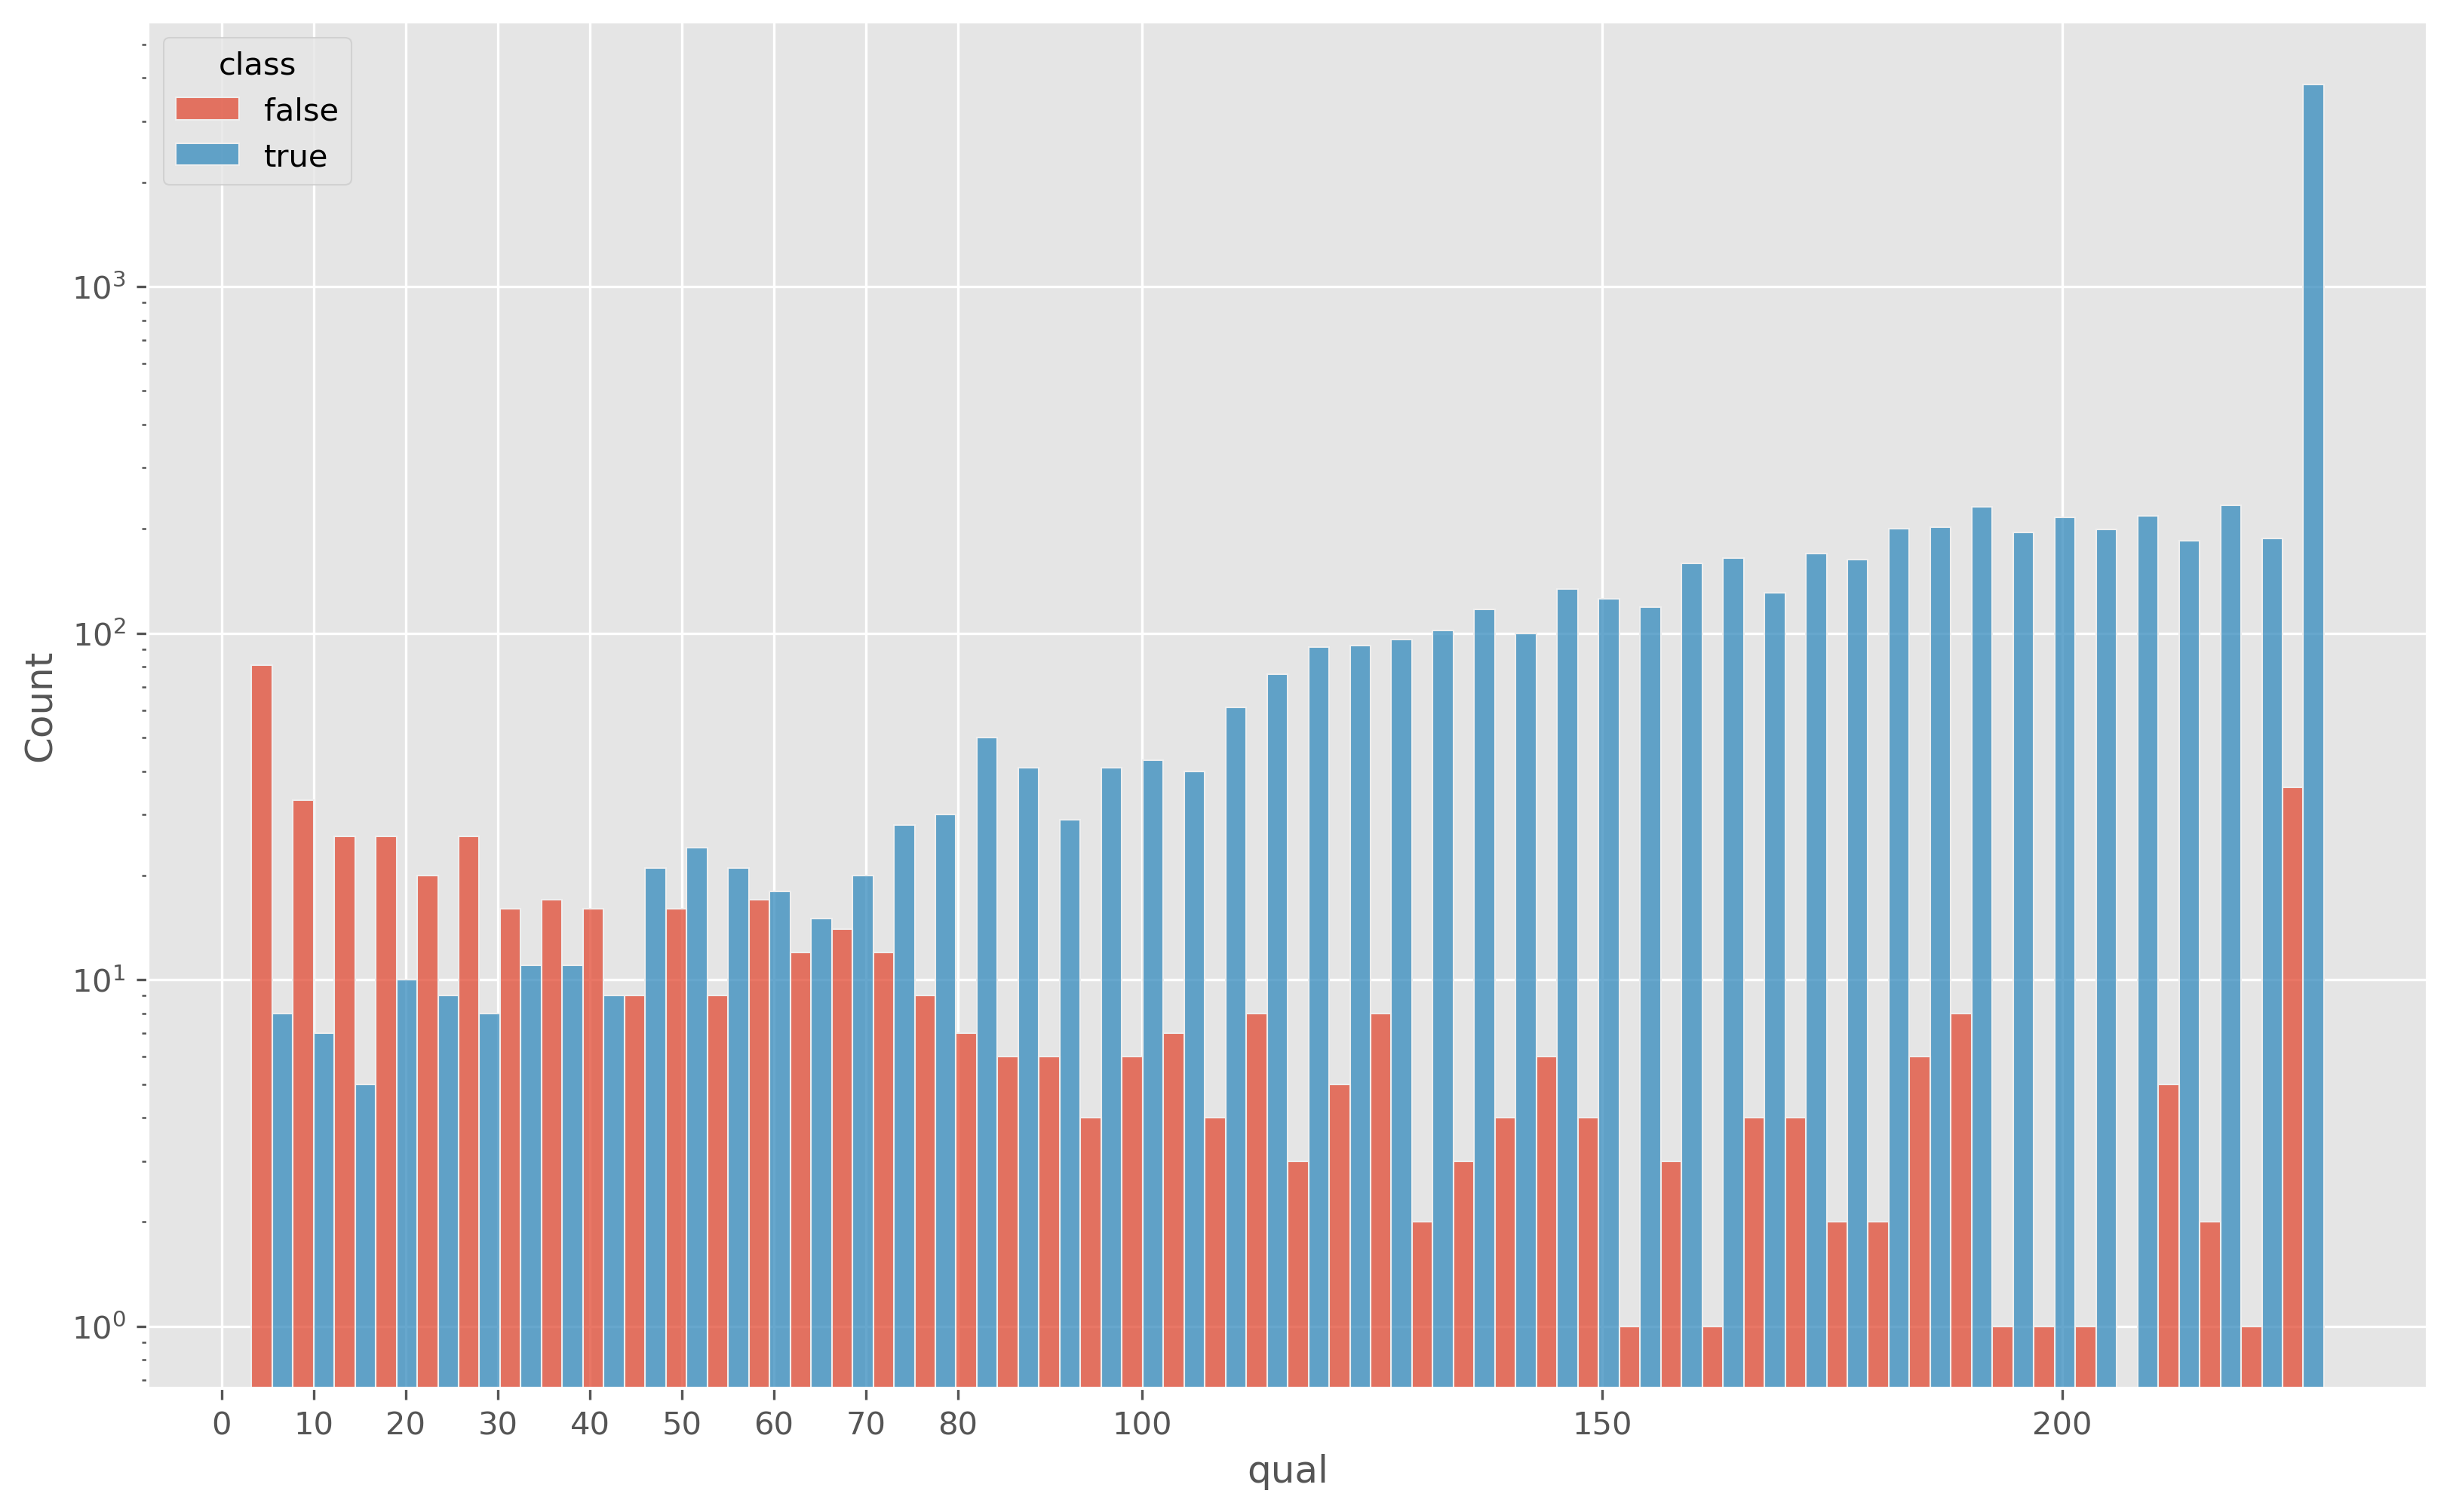

In [25]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="qual", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
xlabels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)

In [21]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.depth"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.depth"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%DP\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [22]:
depths = []
for s in samples:
    depths.extend([float(x) for x in open(stats_dir / f"{s}.false.depth").read().splitlines() if x])
    depths.extend([float(x) for x in open(stats_dir / f"{s}.true.depth").read().splitlines() if x])

df["depth"] = depths

(200.0, 300.0)

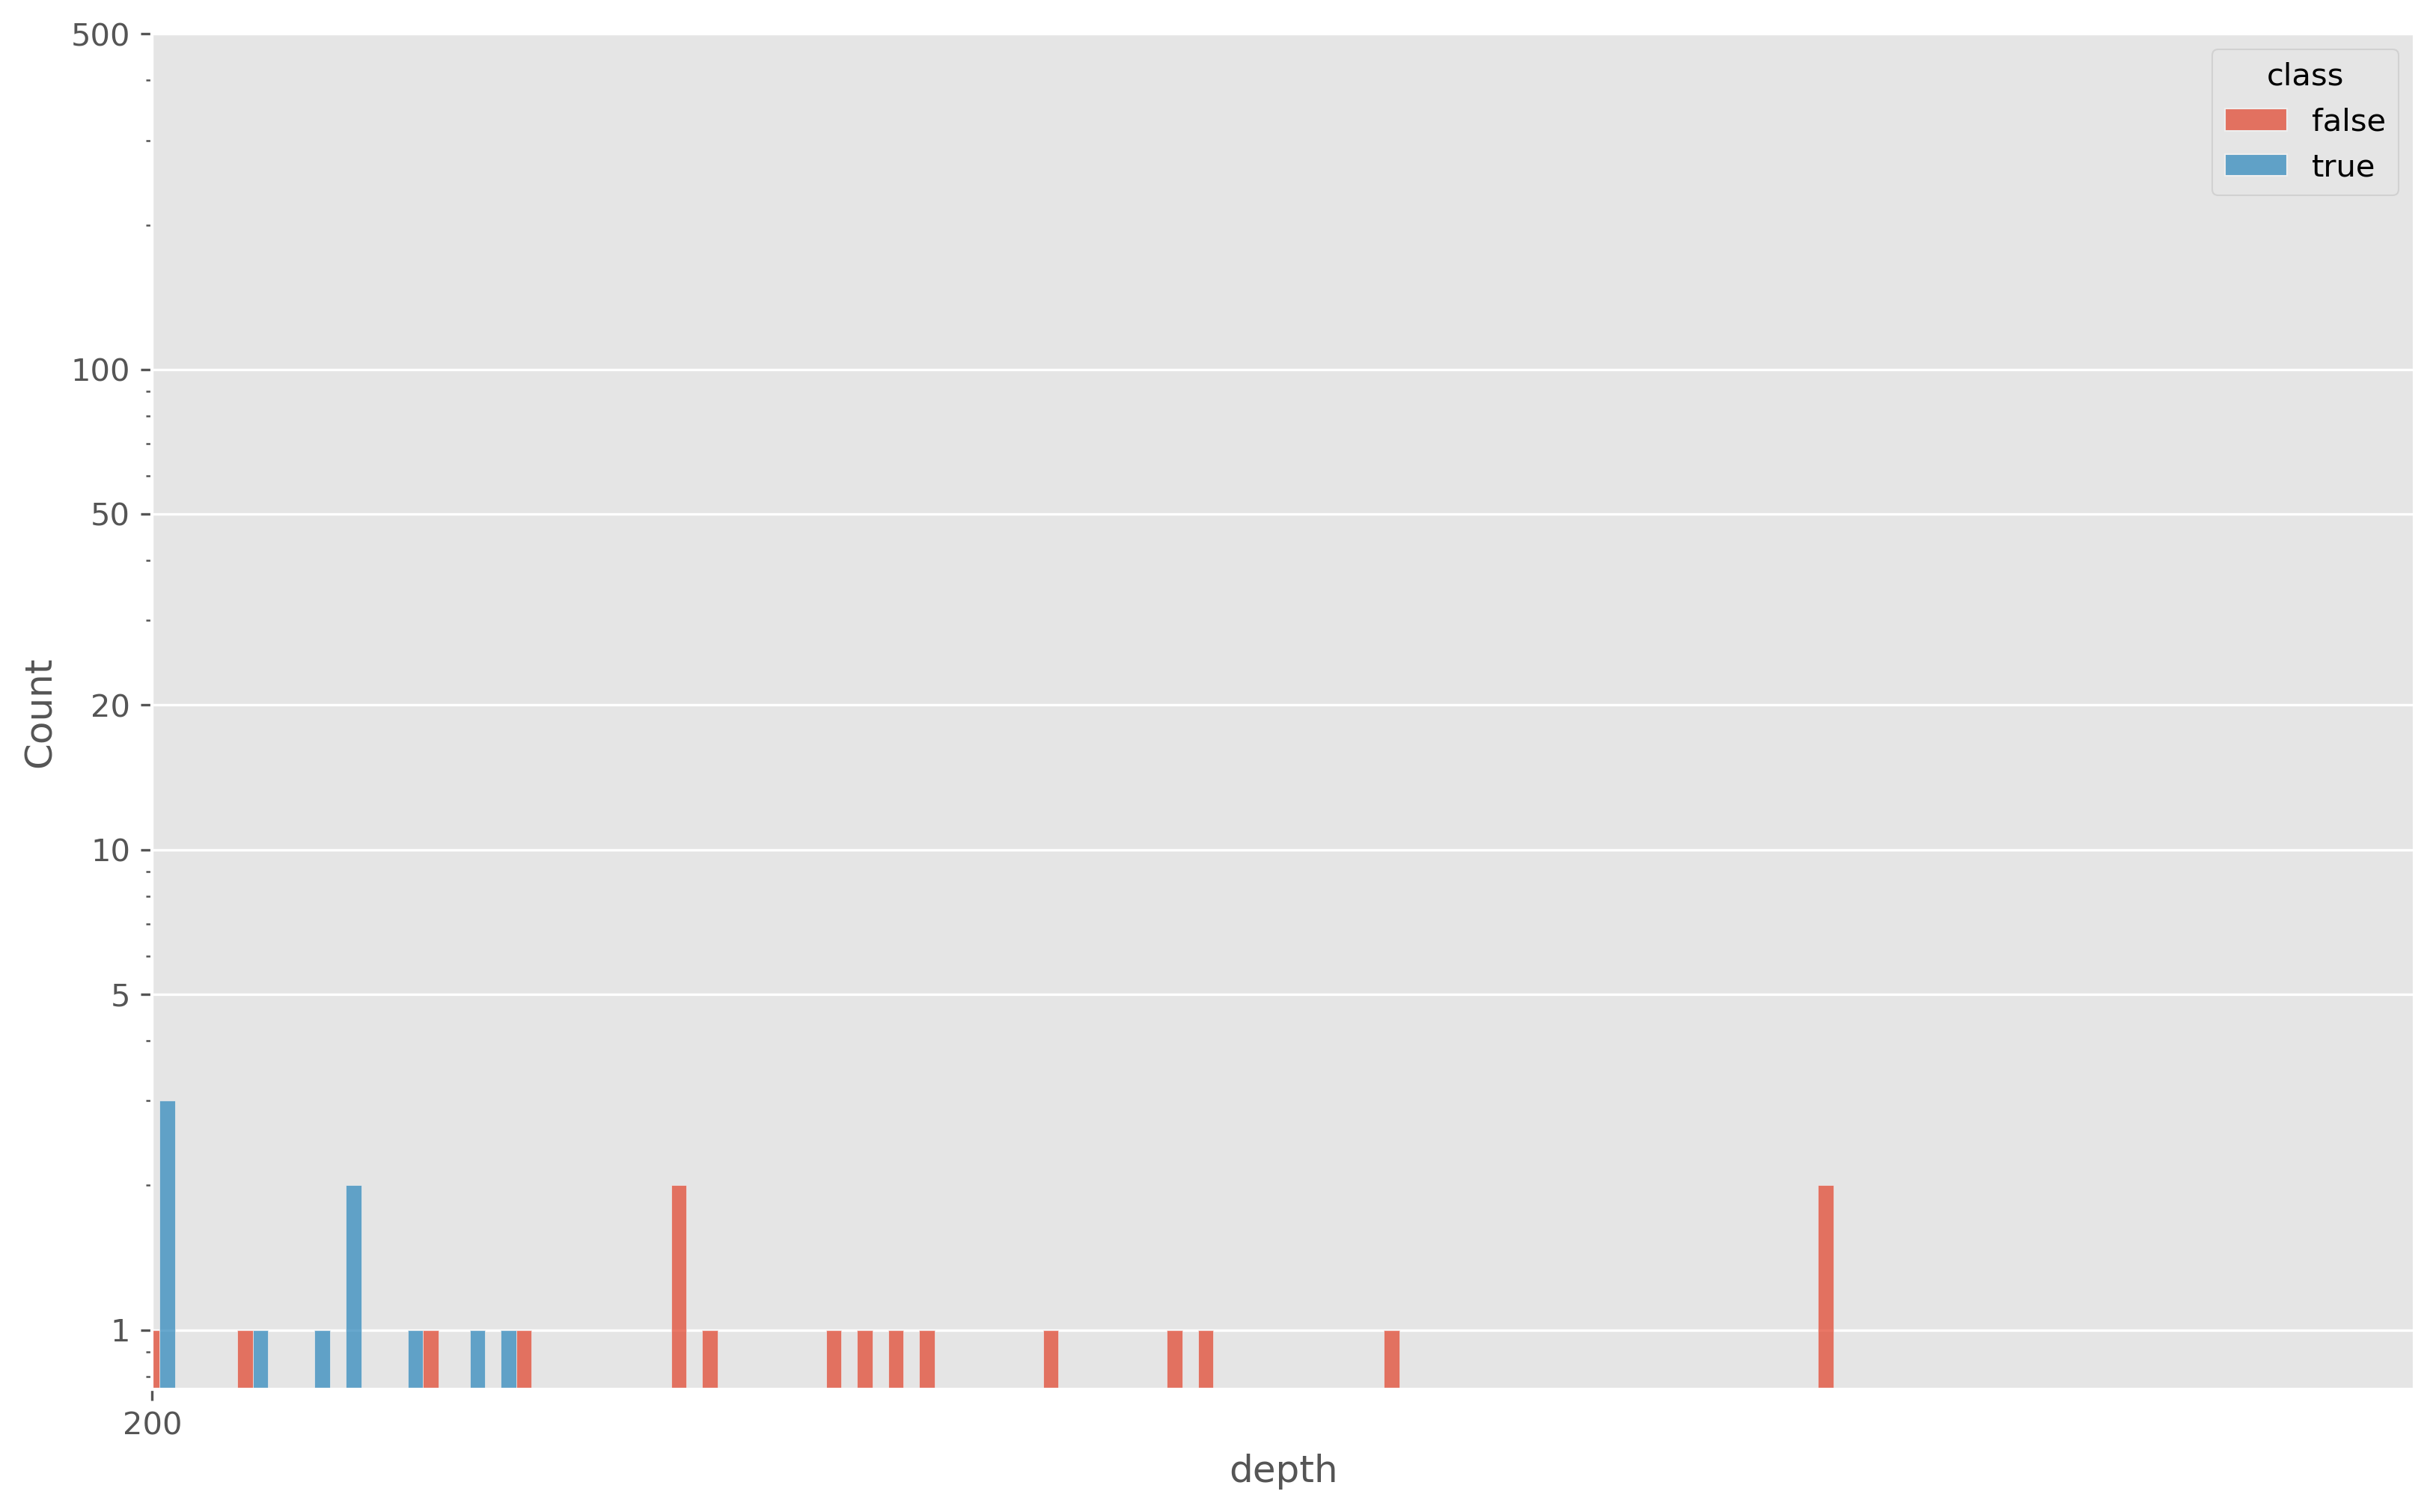

In [76]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="depth", hue="class", multiple="dodge", bins=200)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
xlabels = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.set_xlim((200, 300))

In [23]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.mqbz"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.mqbz"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%MQBZ\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [24]:
mqbz = []
for s in samples:
    mqbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.mqbz").read().splitlines() if x])
    mqbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.mqbz").read().splitlines() if x])

df["mqbz"] = mqbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 800, '800')]

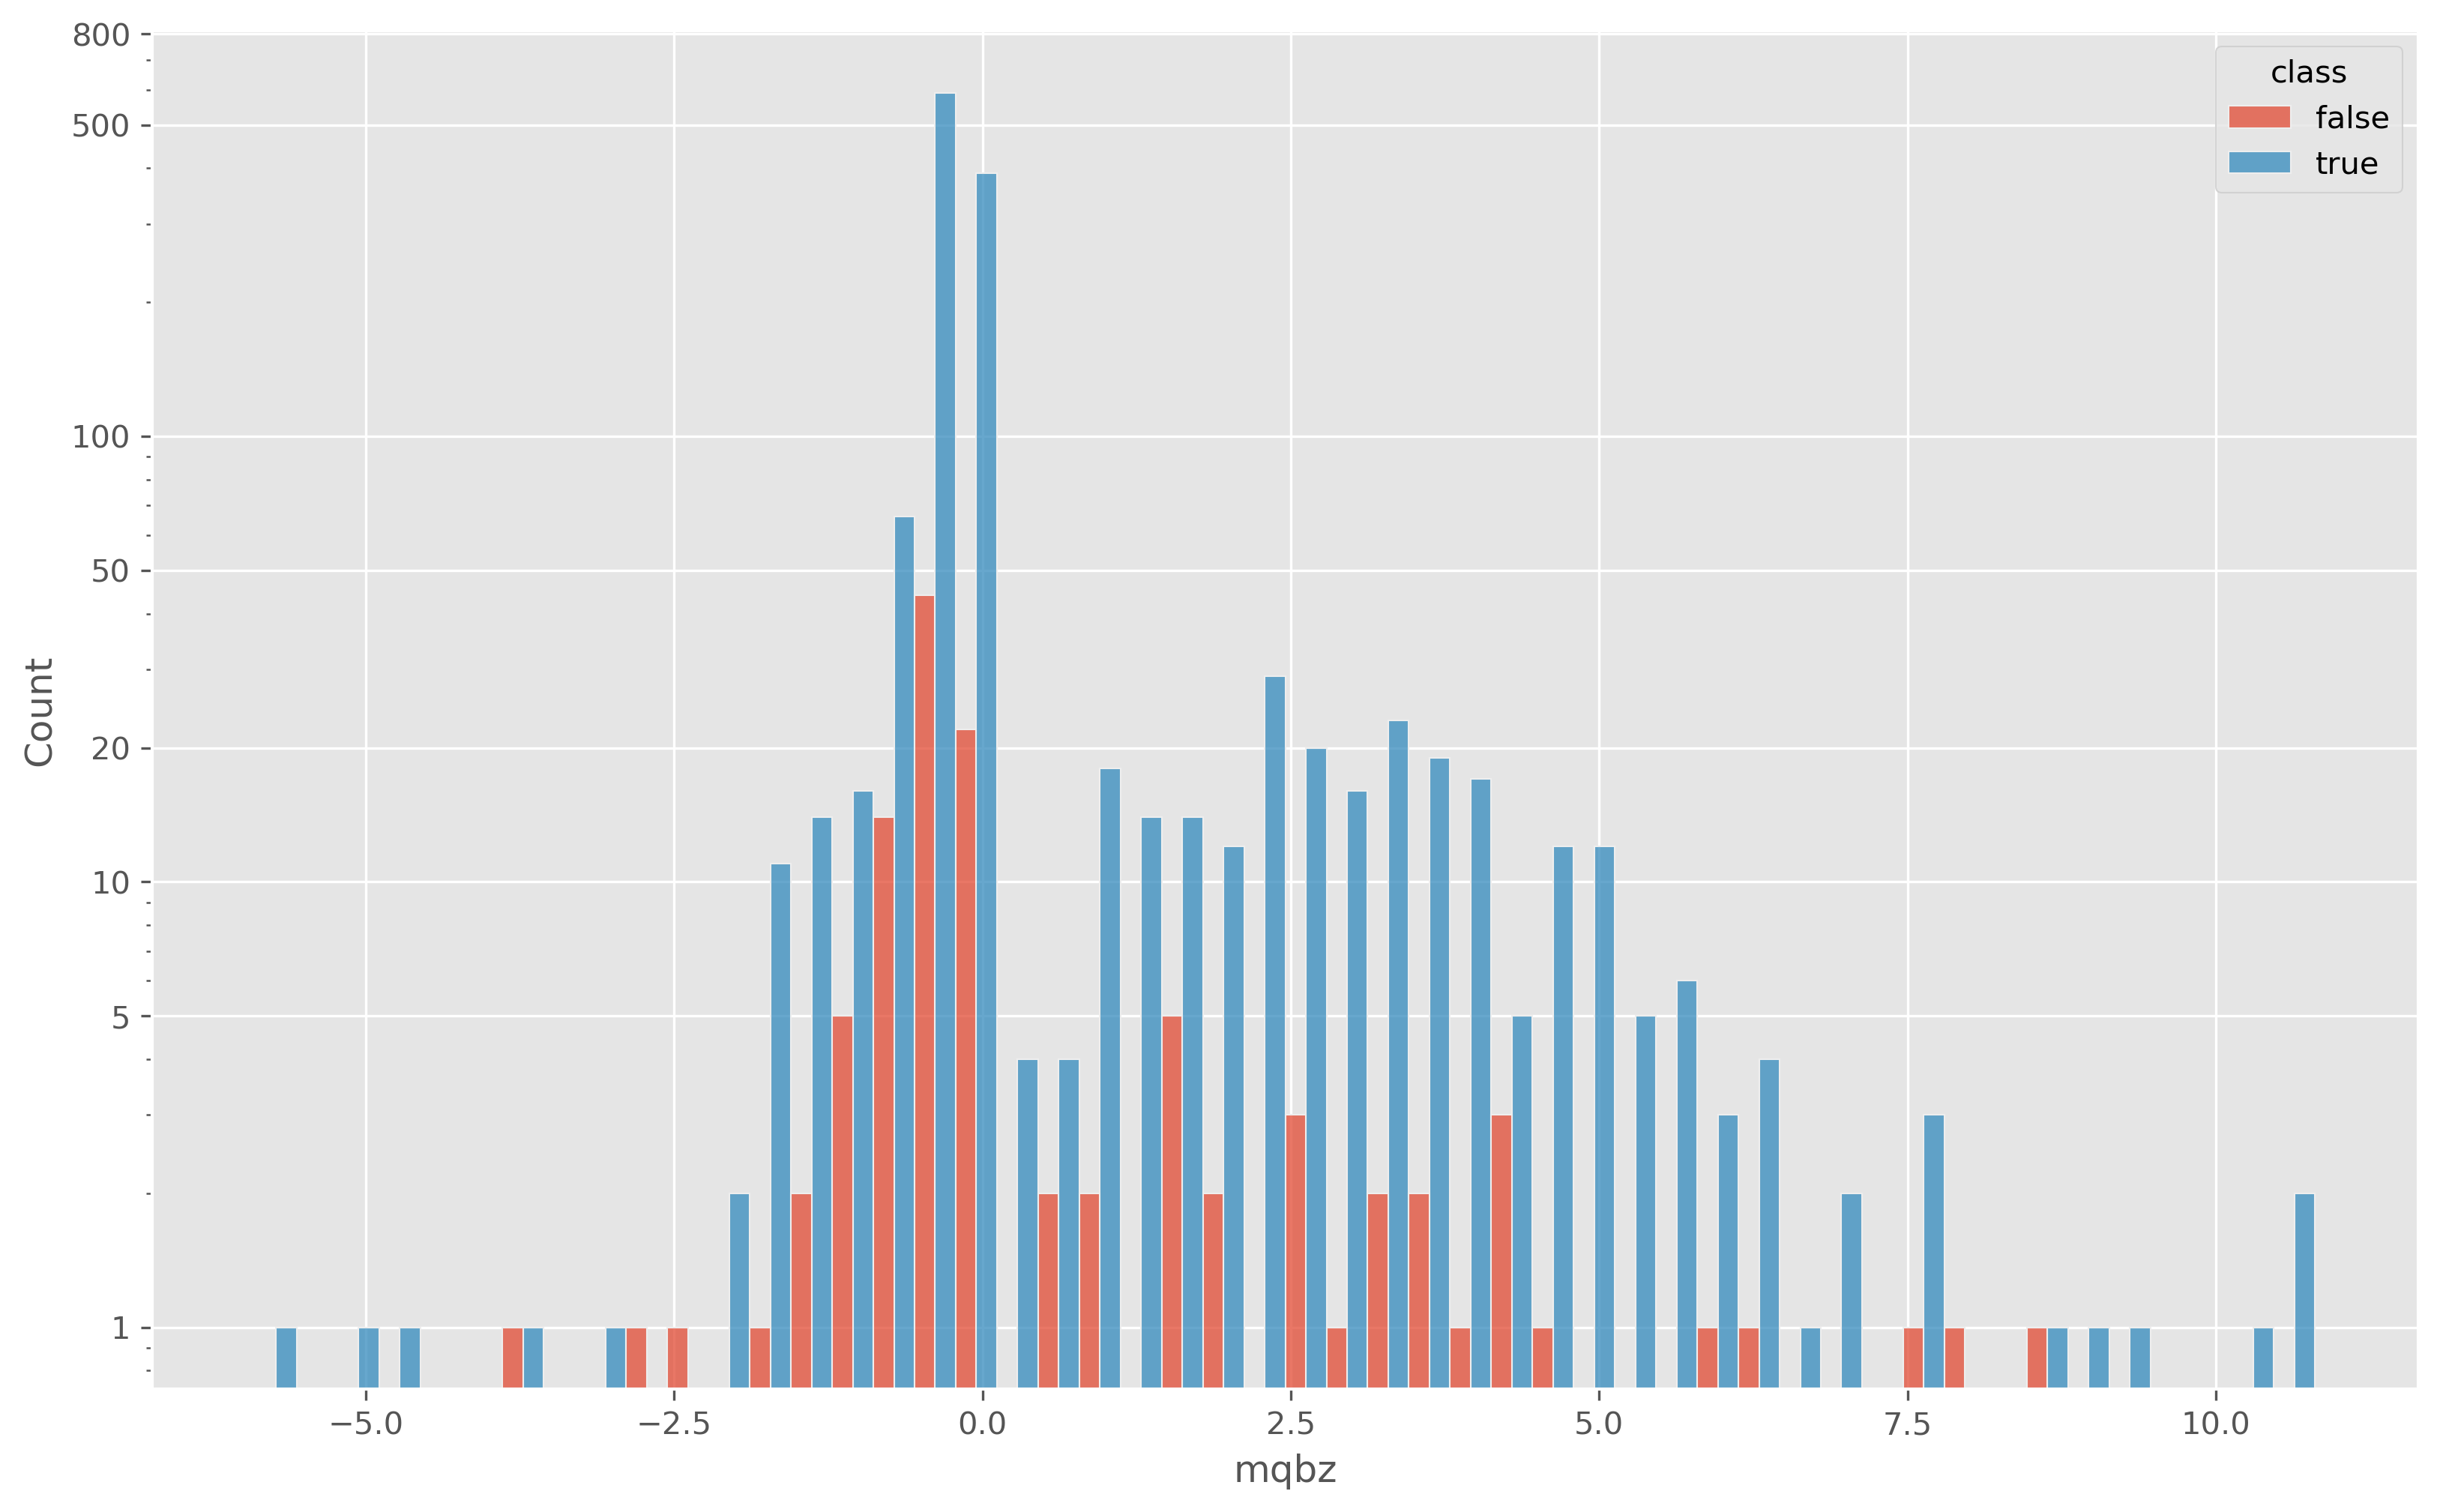

In [77]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="mqbz", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 800]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [25]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.rpbz"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.rpbz"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%RPBZ\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [26]:
rpbz = []
for s in samples:
    rpbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.rpbz").read().splitlines() if x])
    rpbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.rpbz").read().splitlines() if x])

df["rpbz"] = rpbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500')]

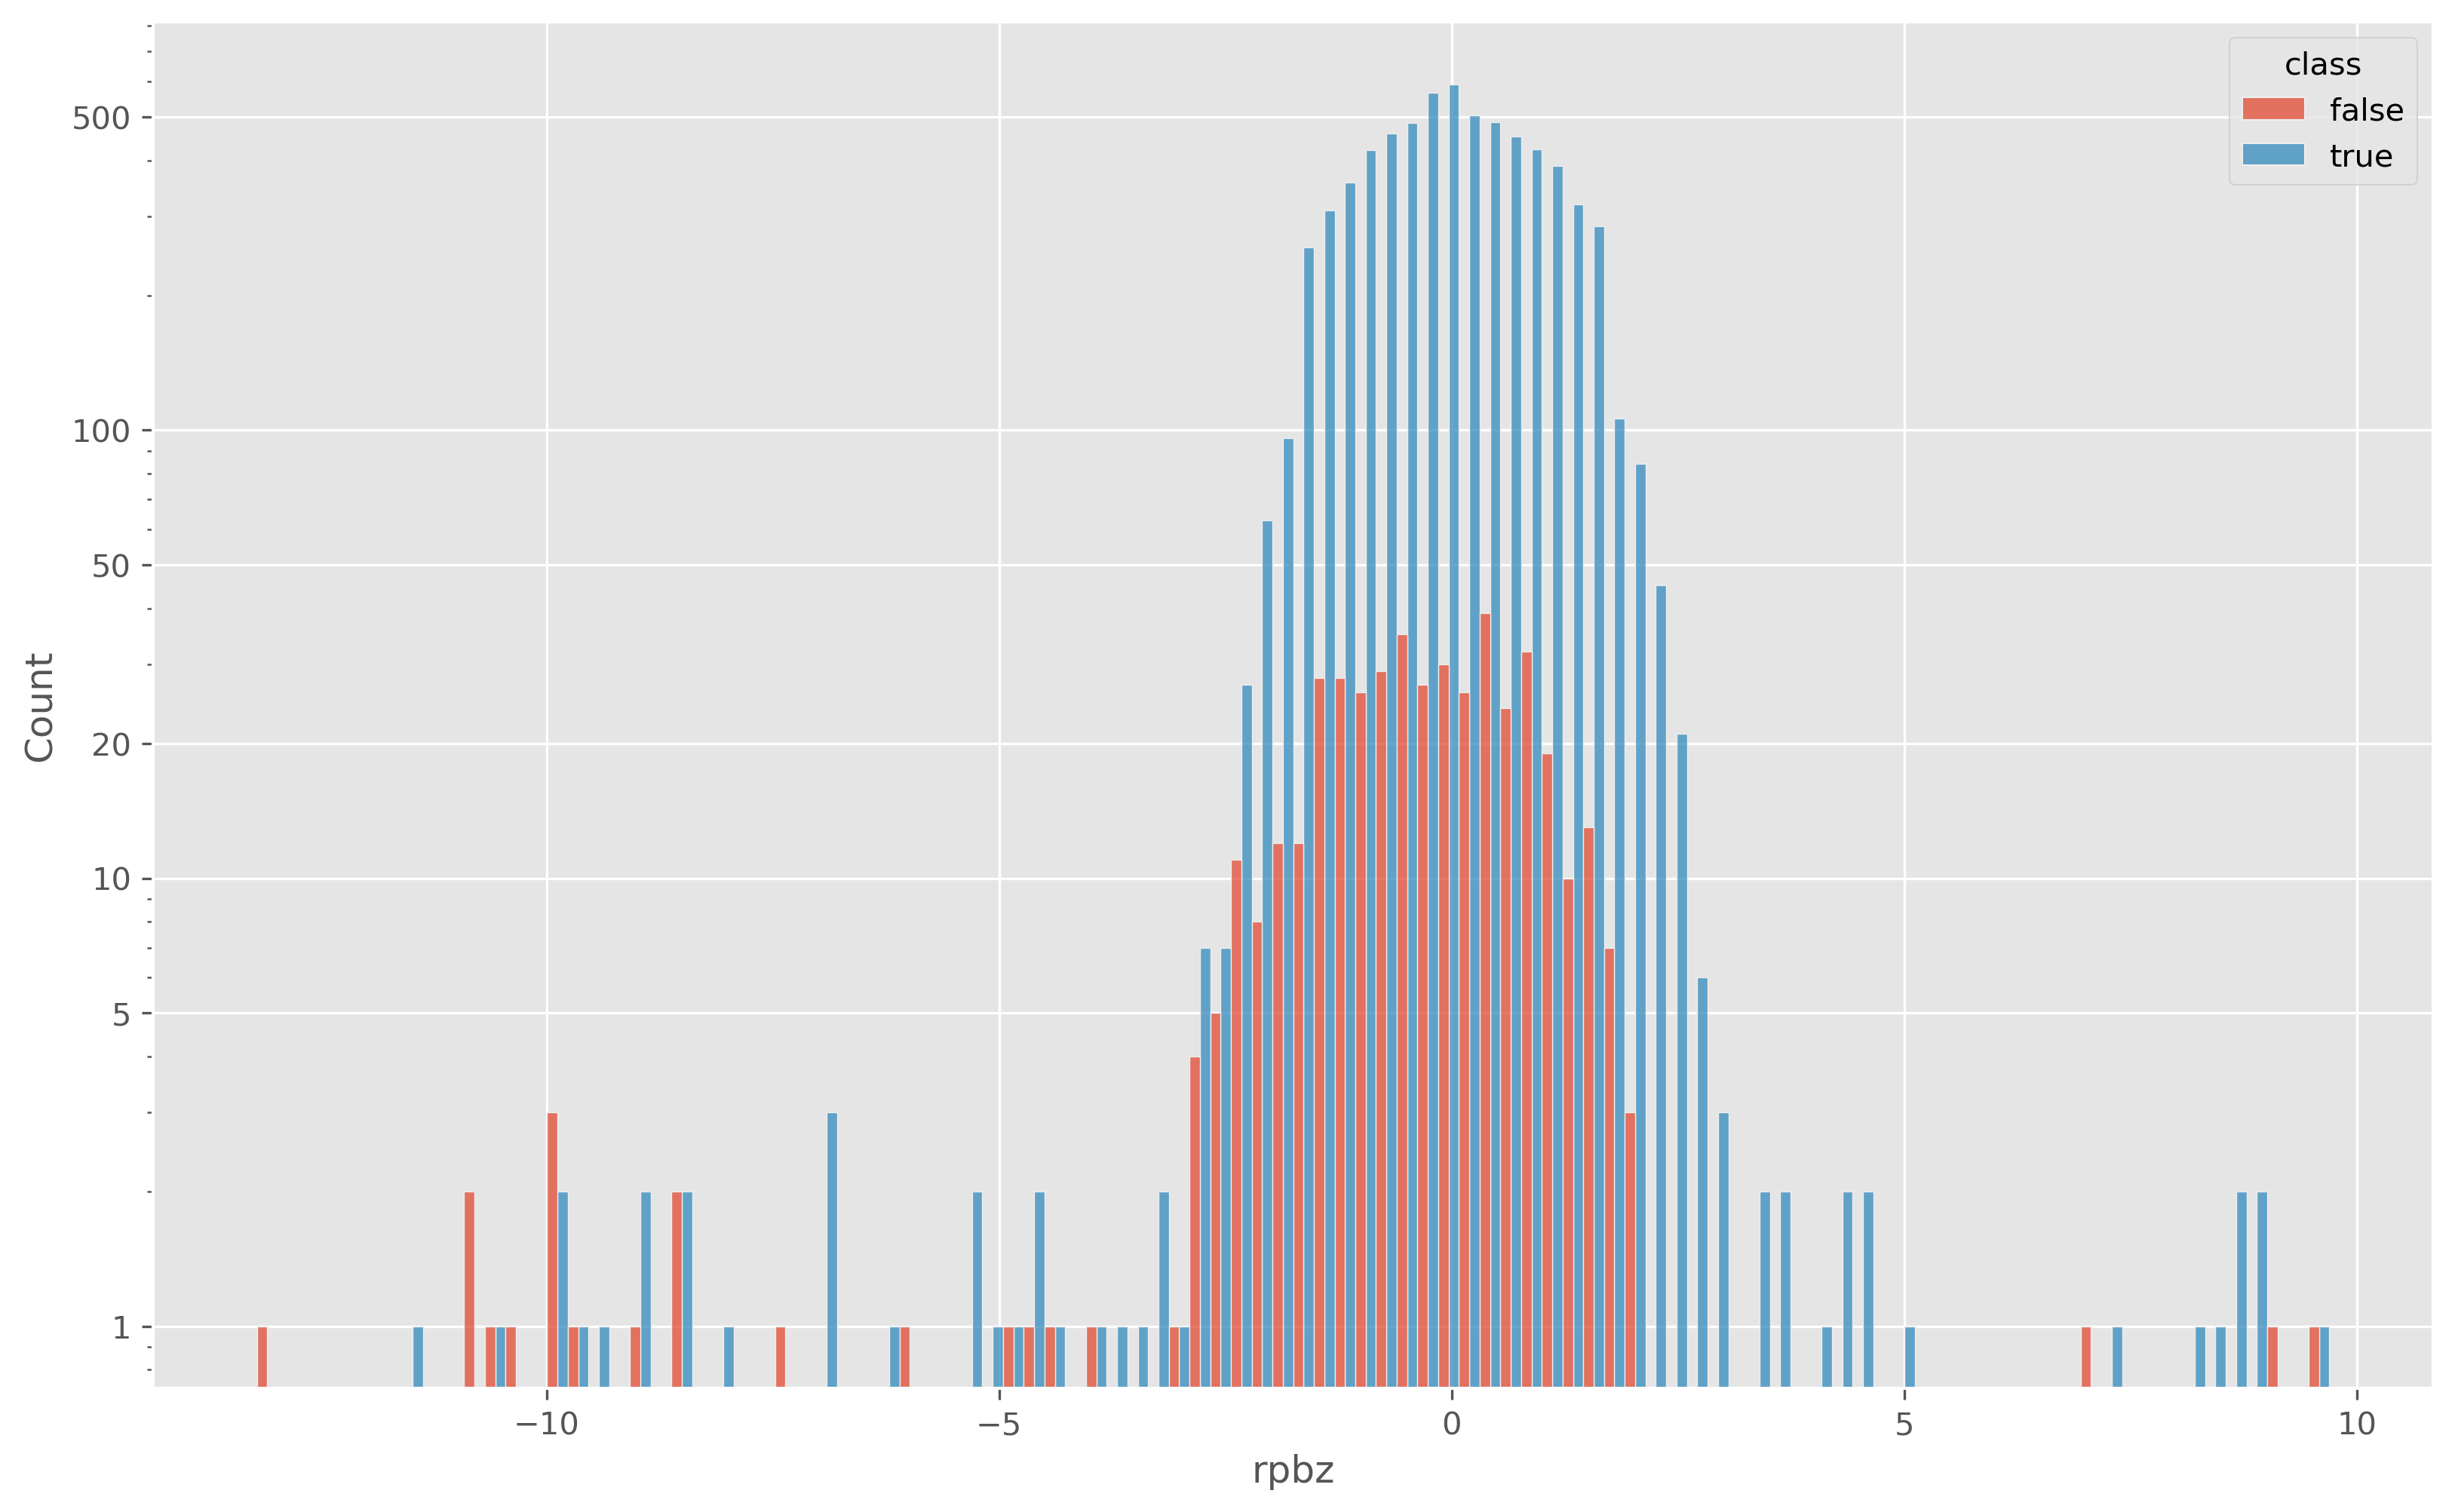

In [80]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="rpbz", hue="class", multiple="dodge", bins=100)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [27]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.scbz"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.scbz"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%SCBZ\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [28]:
scbz = []
for s in samples:
    scbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.scbz").read().splitlines() if x])
    scbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.scbz").read().splitlines() if x])

df["scbz"] = scbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 1000, '1000')]

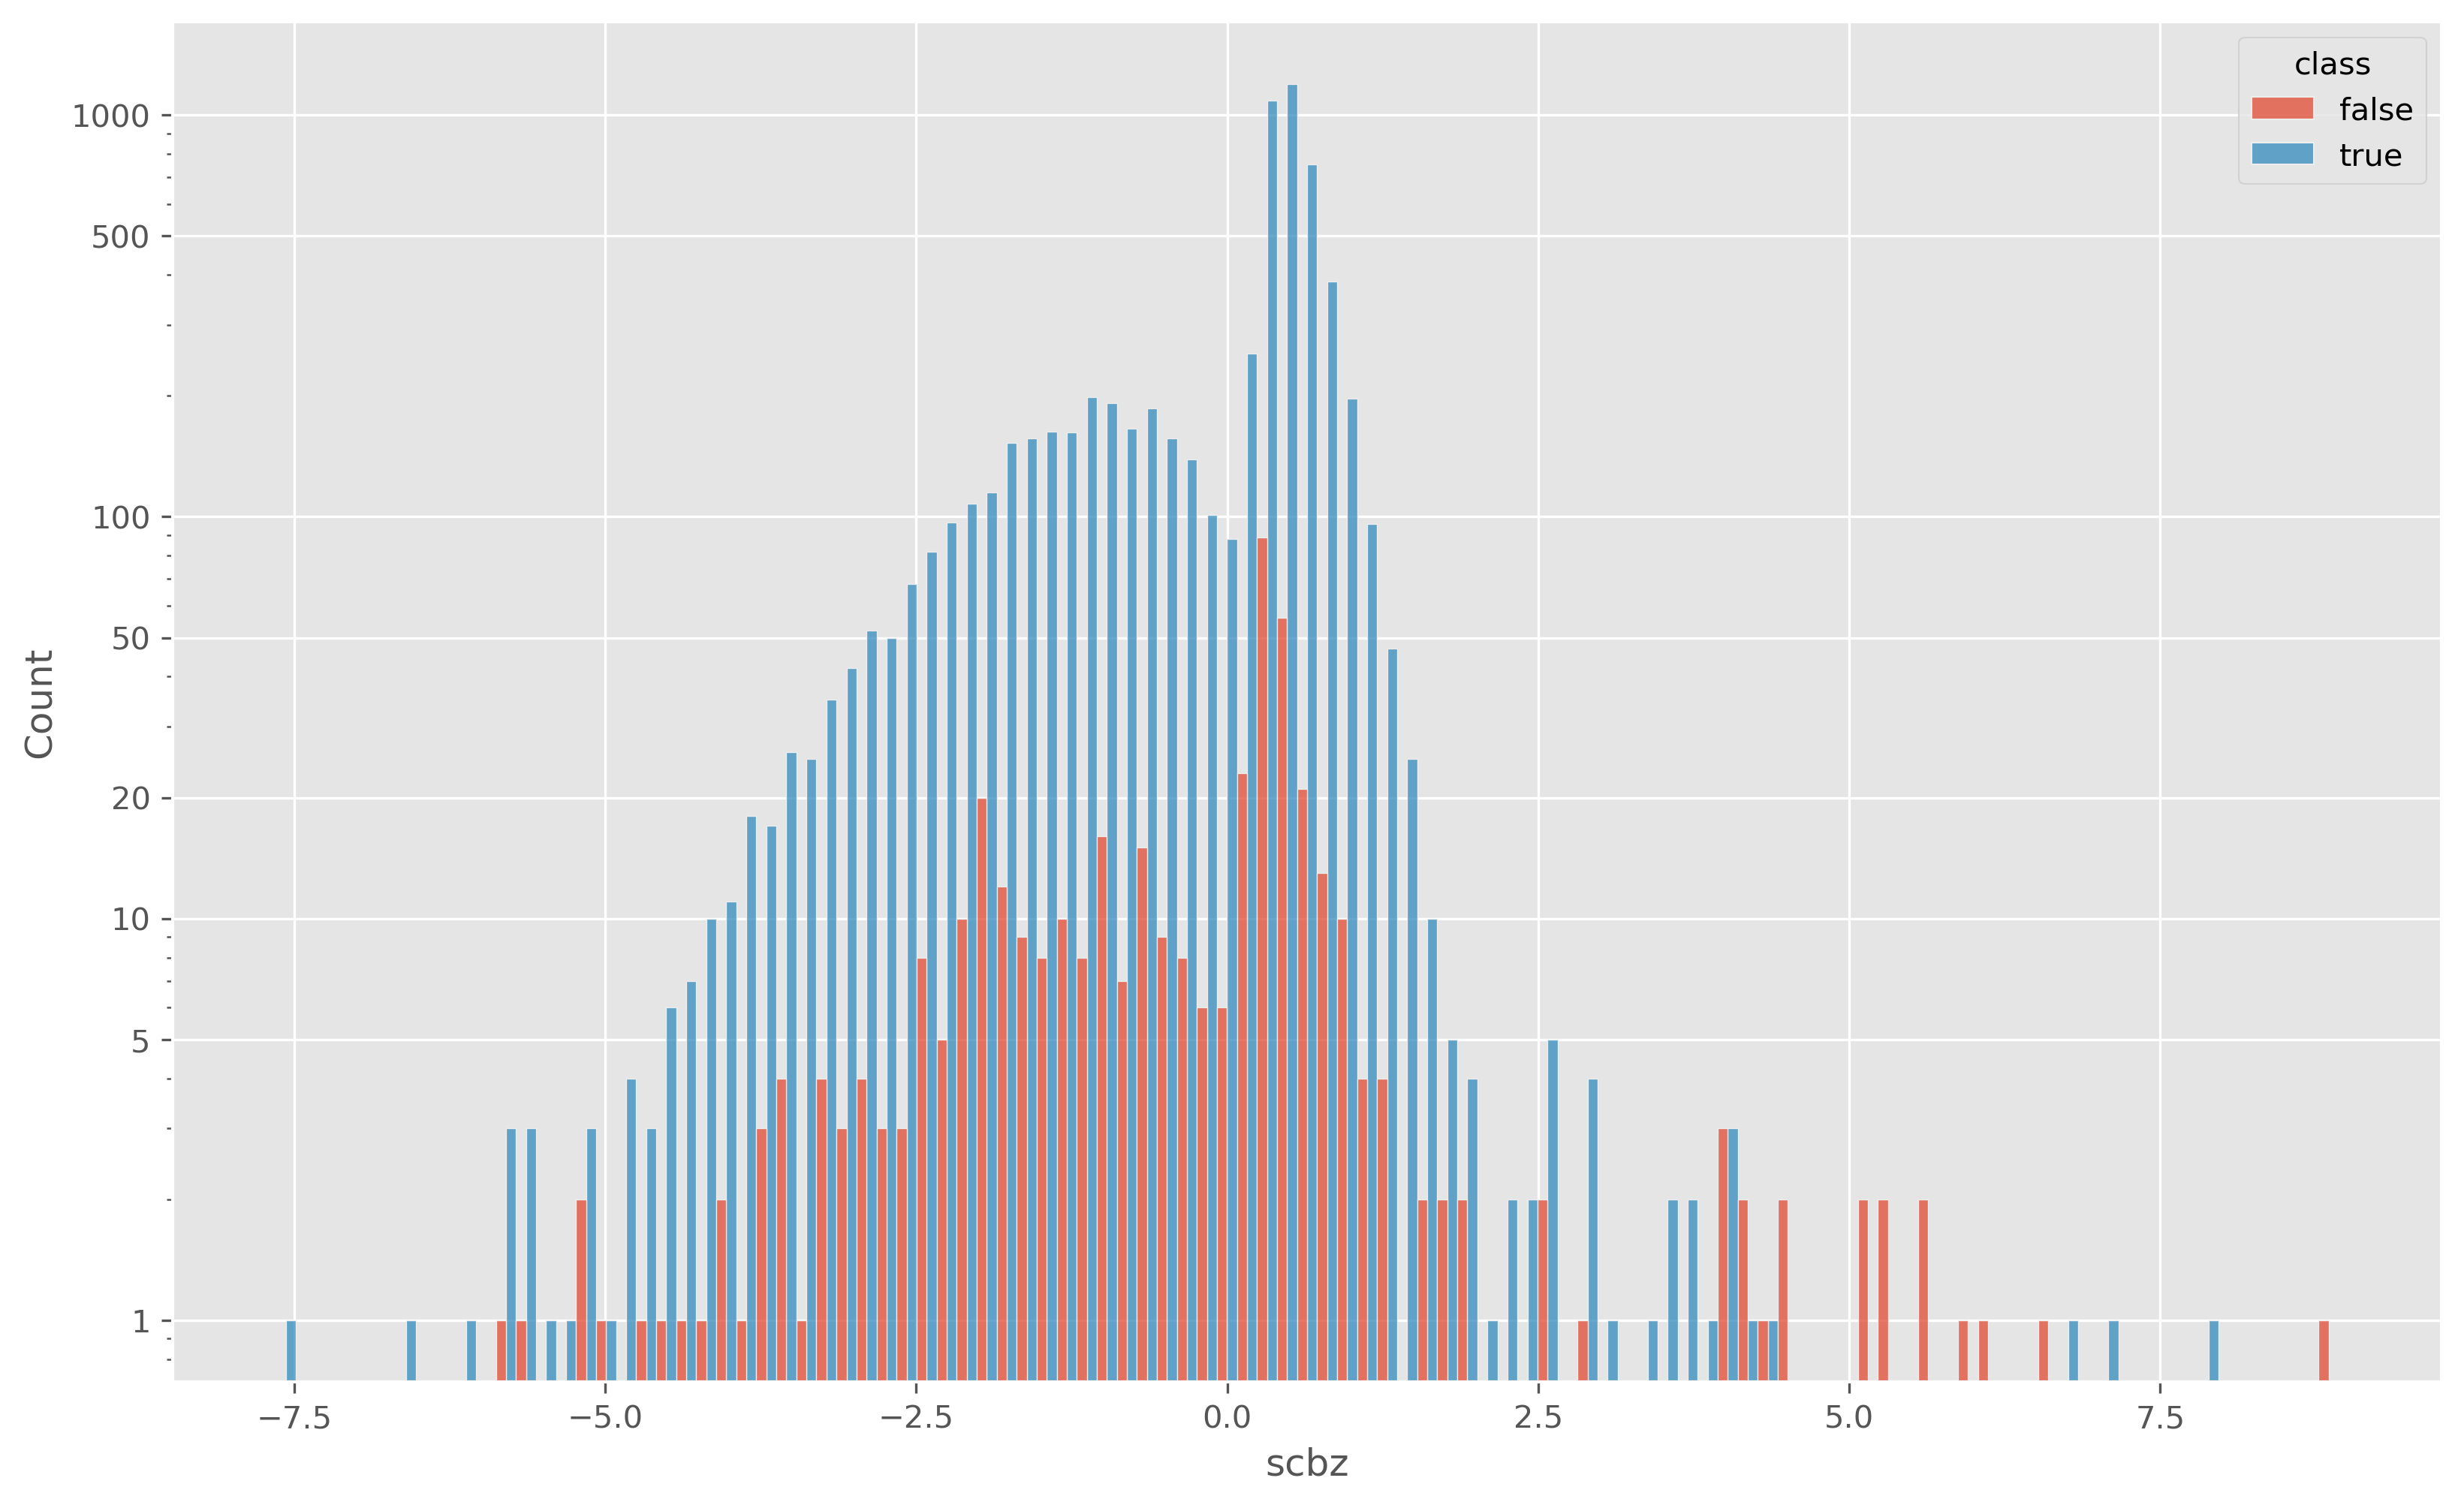

In [37]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="scbz", hue="class", multiple="dodge", )
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [29]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.sp"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.sp"
#         opts = f"-i 'TYPE=\"SNP\"' -f '[%SP]\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [30]:
sp = []
for s in samples:
    sp.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.sp").read().splitlines() if x])
    sp.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.sp").read().splitlines() if x])

df["sp"] = sp

(0.0, 100.0)

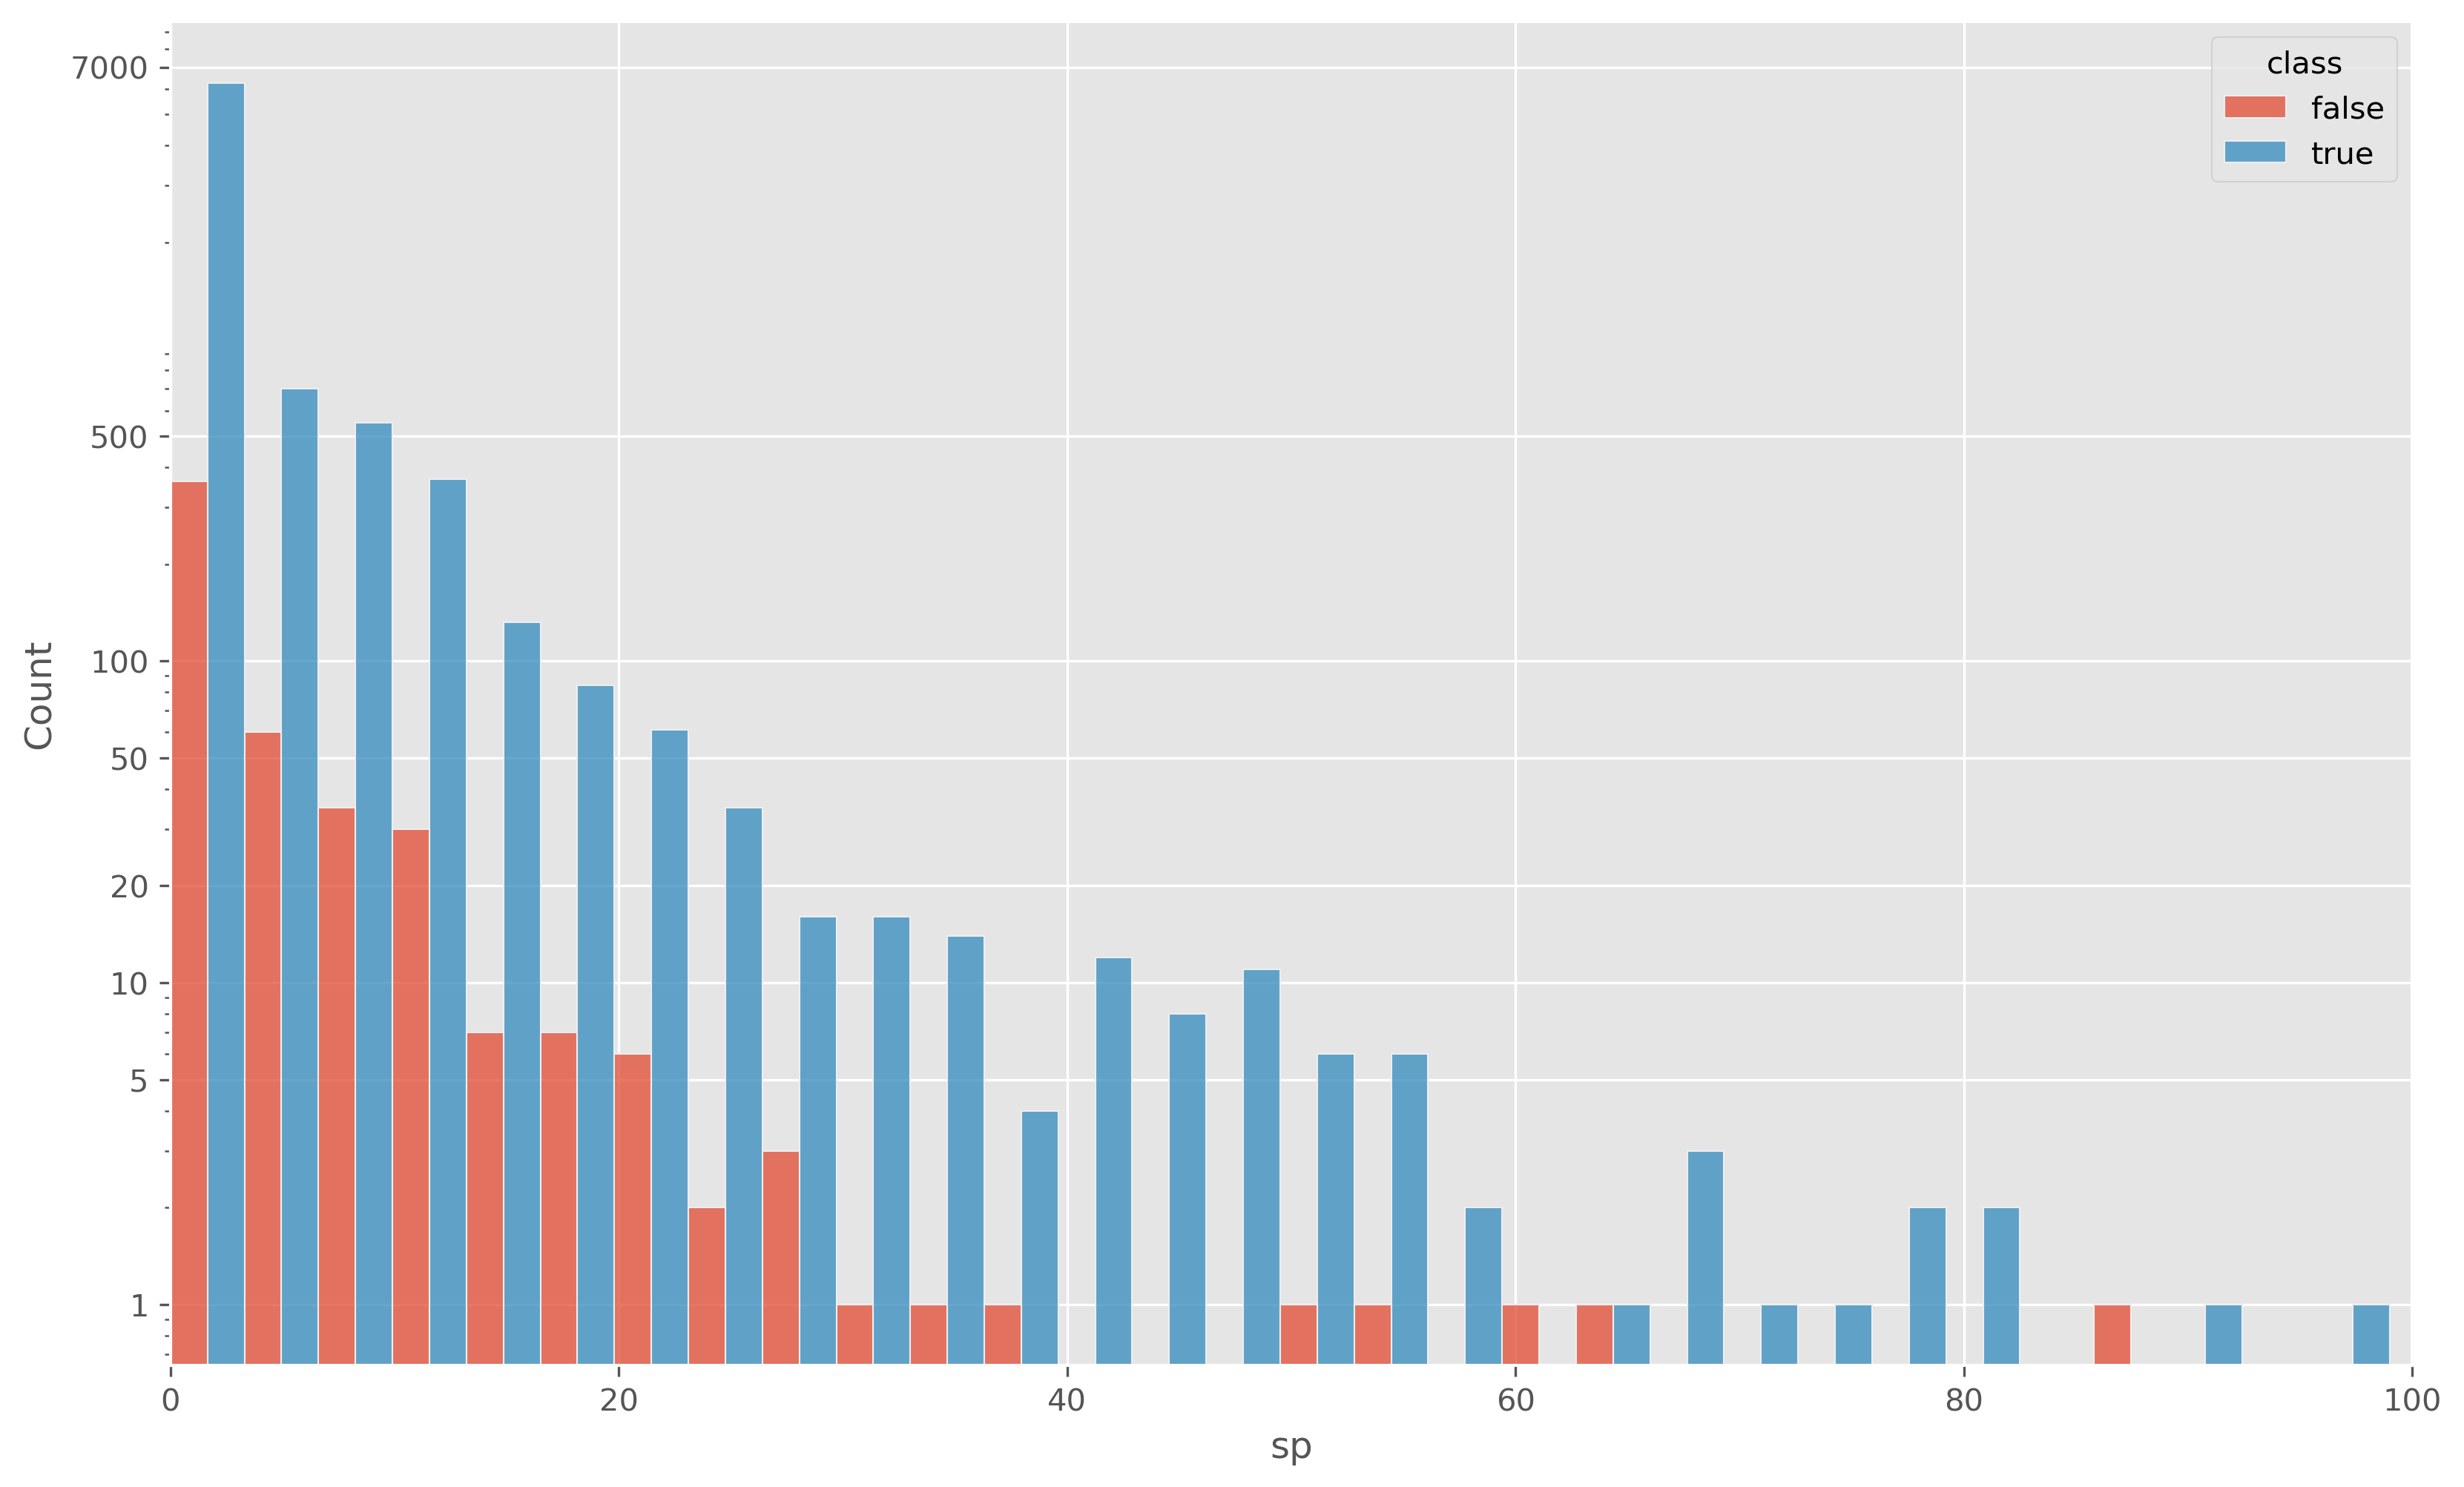

In [81]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="sp", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 7000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
ax.set_xlim((0, 100))

In [31]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.scr"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.scr"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%SCR\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [32]:
scr = []
for s in samples:
    scr.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.scr").read().splitlines() if x])
    scr.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.scr").read().splitlines() if x])

df["scr"] = scr

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 1000, '1000')]

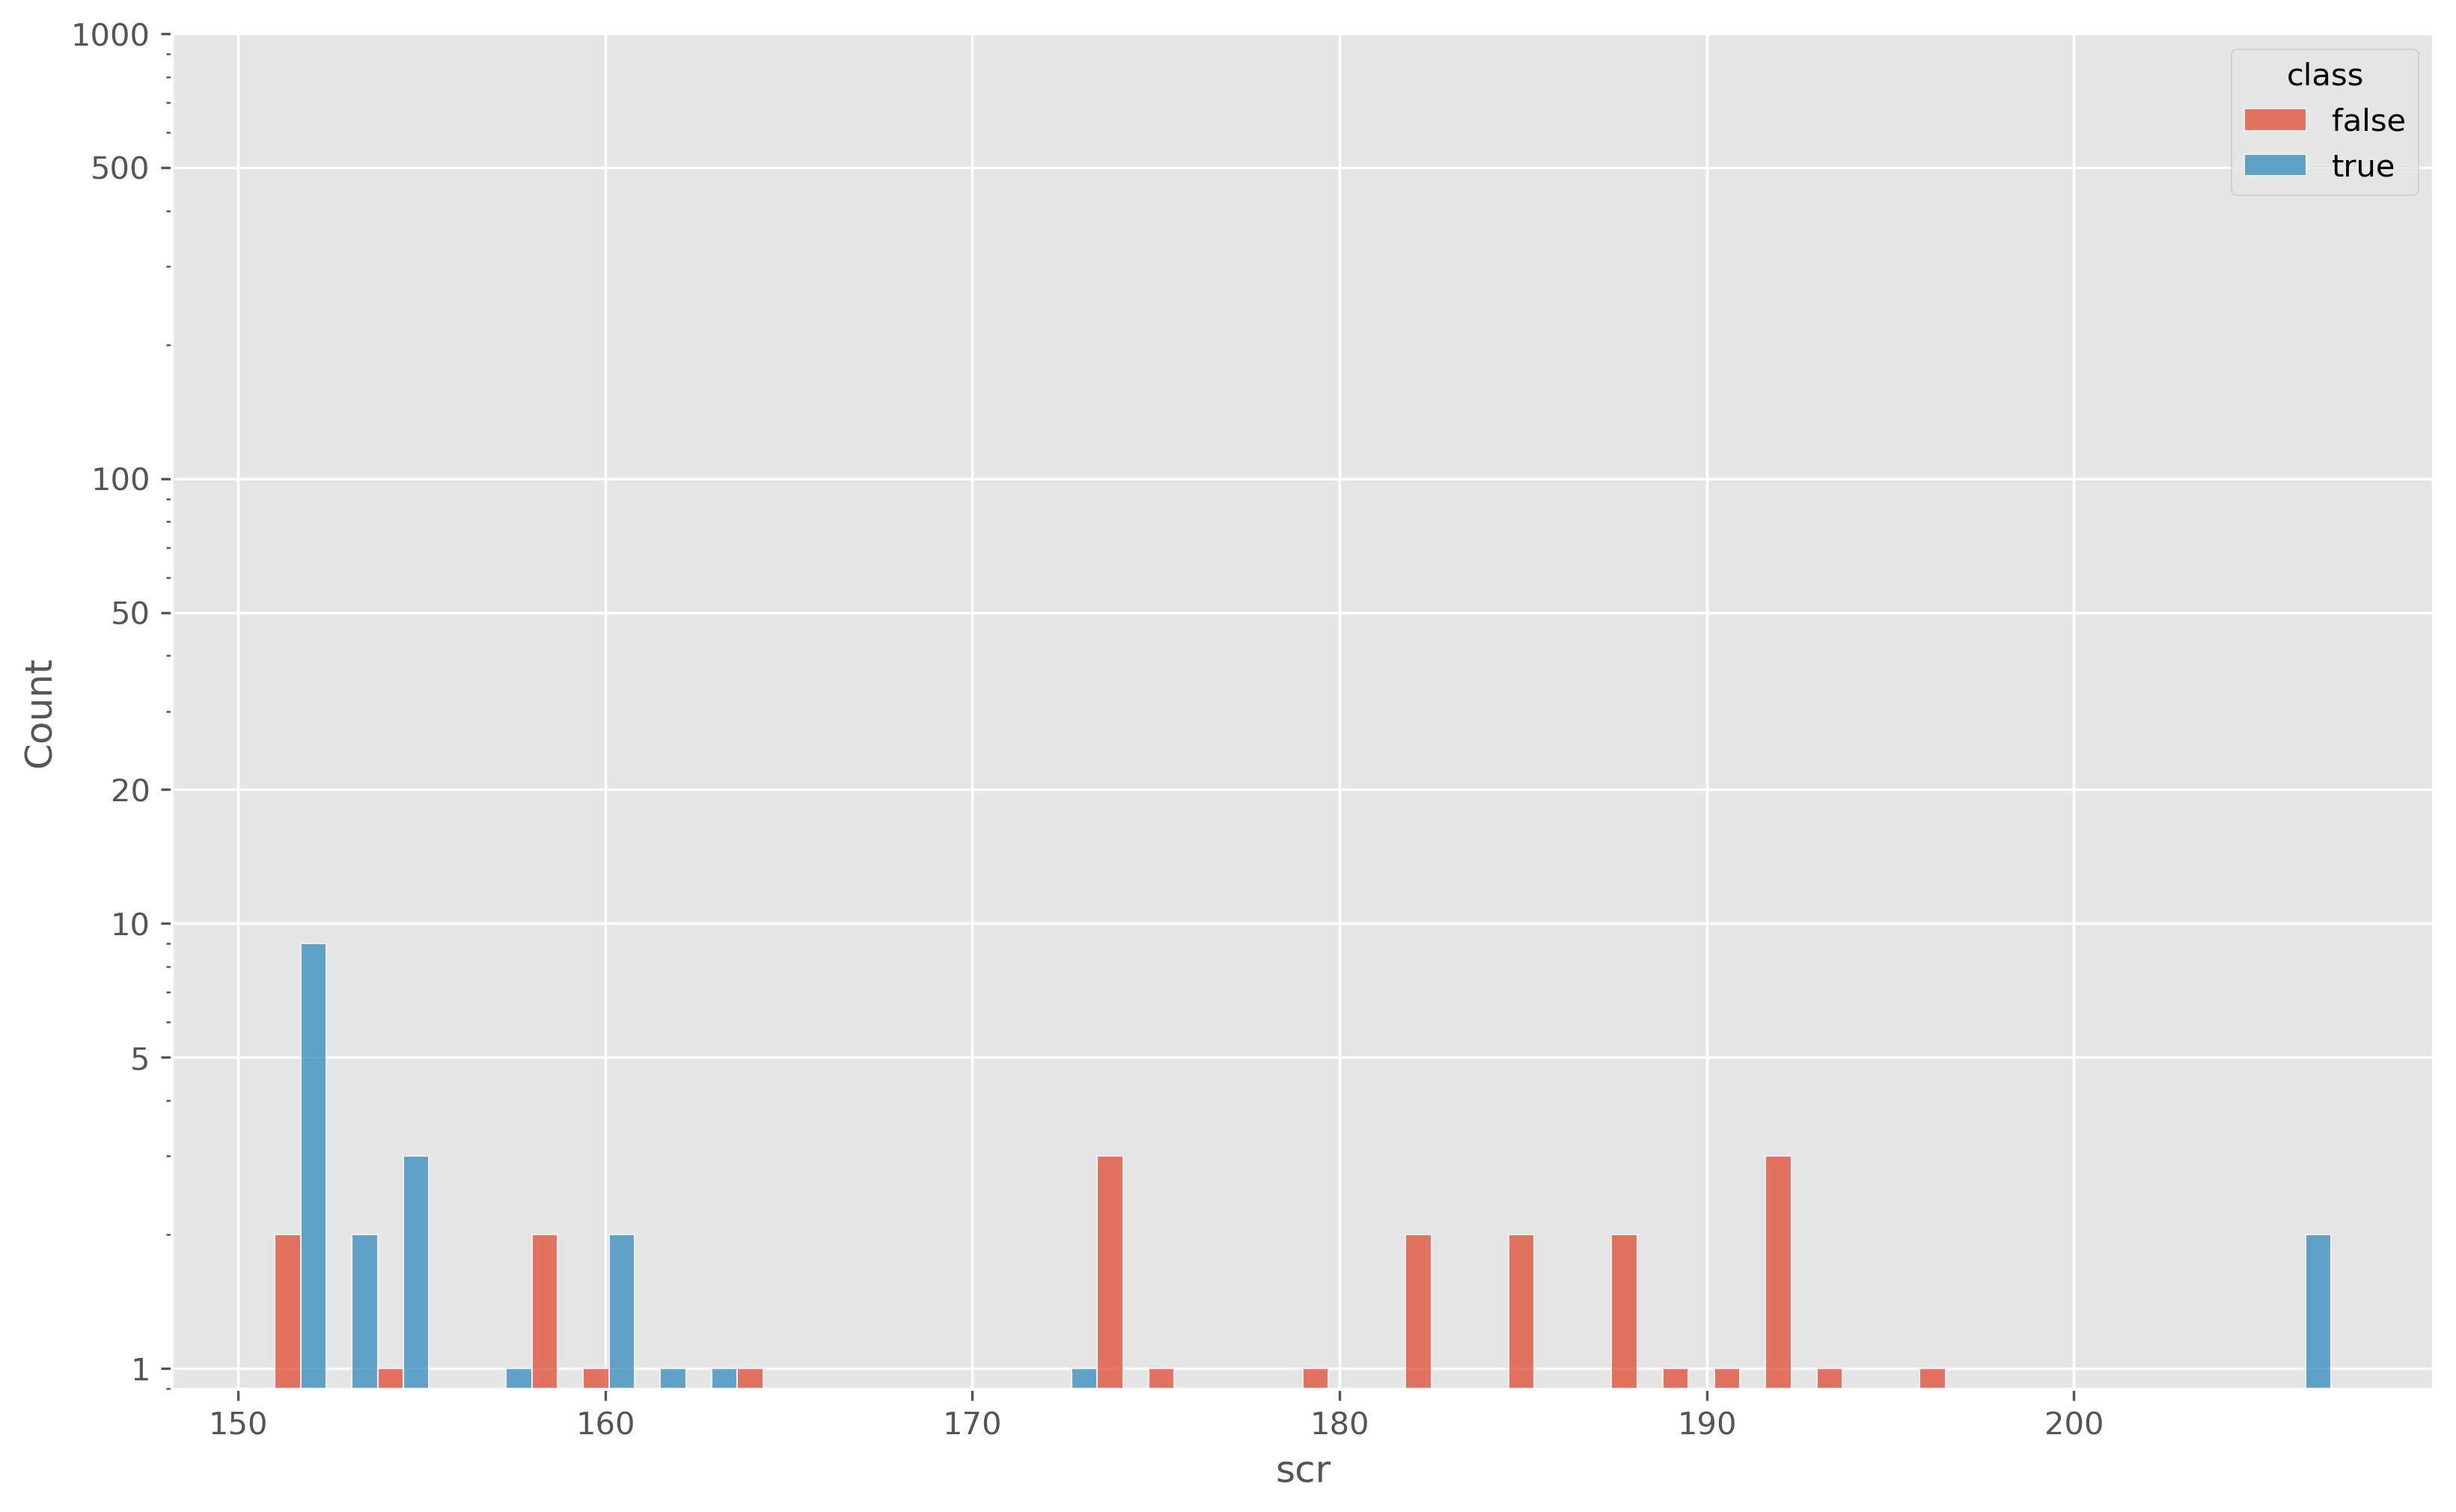

In [64]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df.query("scr>150"), x="scr", hue="class", multiple="dodge", bins=40)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [33]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.dp4"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.dp4"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%DP4\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [34]:
frs = []
for s in samples:
    for line in open(stats_dir / f"{s}.false.dp4").read().splitlines():
        rf, rr, af, ar = [int(i) for i in line.split(",")]
        r = rf+rr
        a = af+ar
        frs.append(max(a, r)/(a+r))
    for line in open(stats_dir / f"{s}.true.dp4").read().splitlines():
        rf, rr, af, ar = [int(i) for i in line.split(",")]
        r = rf+rr
        a = af+ar
        frs.append(max(a, r)/(a+r))

df["frs"] = frs

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

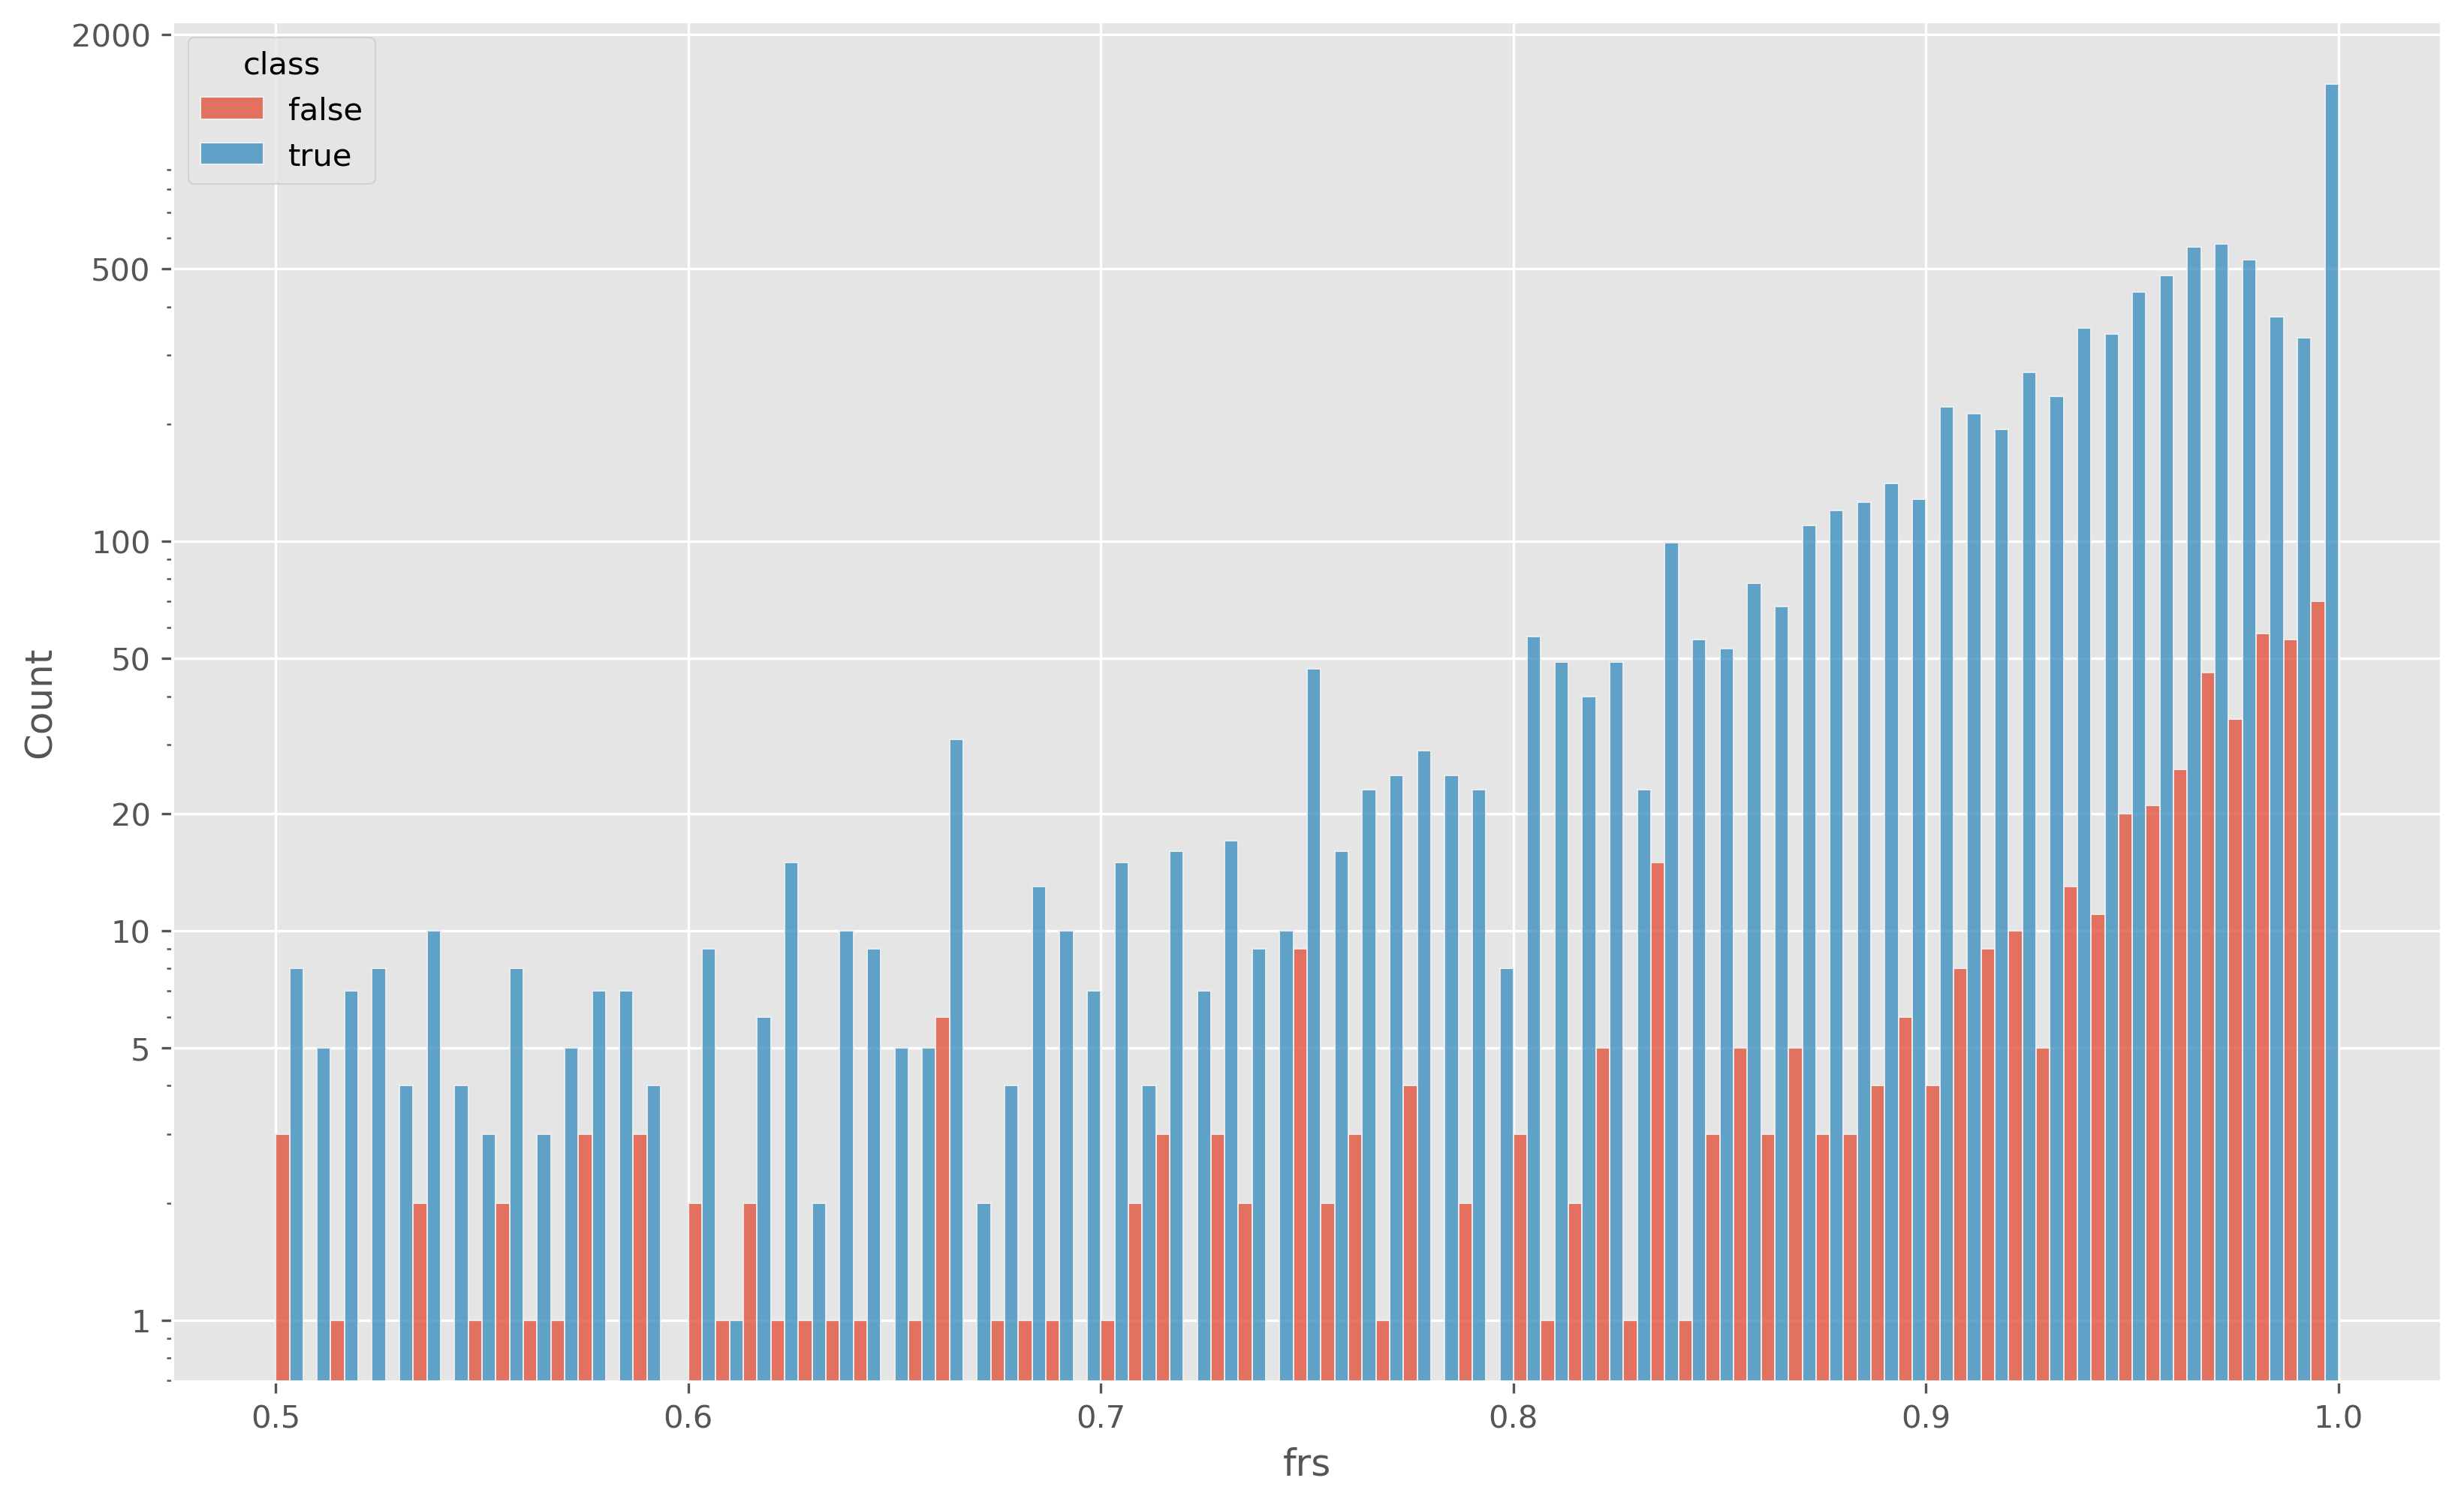

In [46]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="frs", hue="class", multiple="dodge", )
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [35]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.vdb"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.vdb"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%VDB\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [36]:
vdb = []
for s in samples:
    vdb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.vdb").read().splitlines() if x])
    vdb.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.vdb").read().splitlines() if x])

df["vdb"] = vdb

<AxesSubplot:xlabel='vdb', ylabel='Count'>

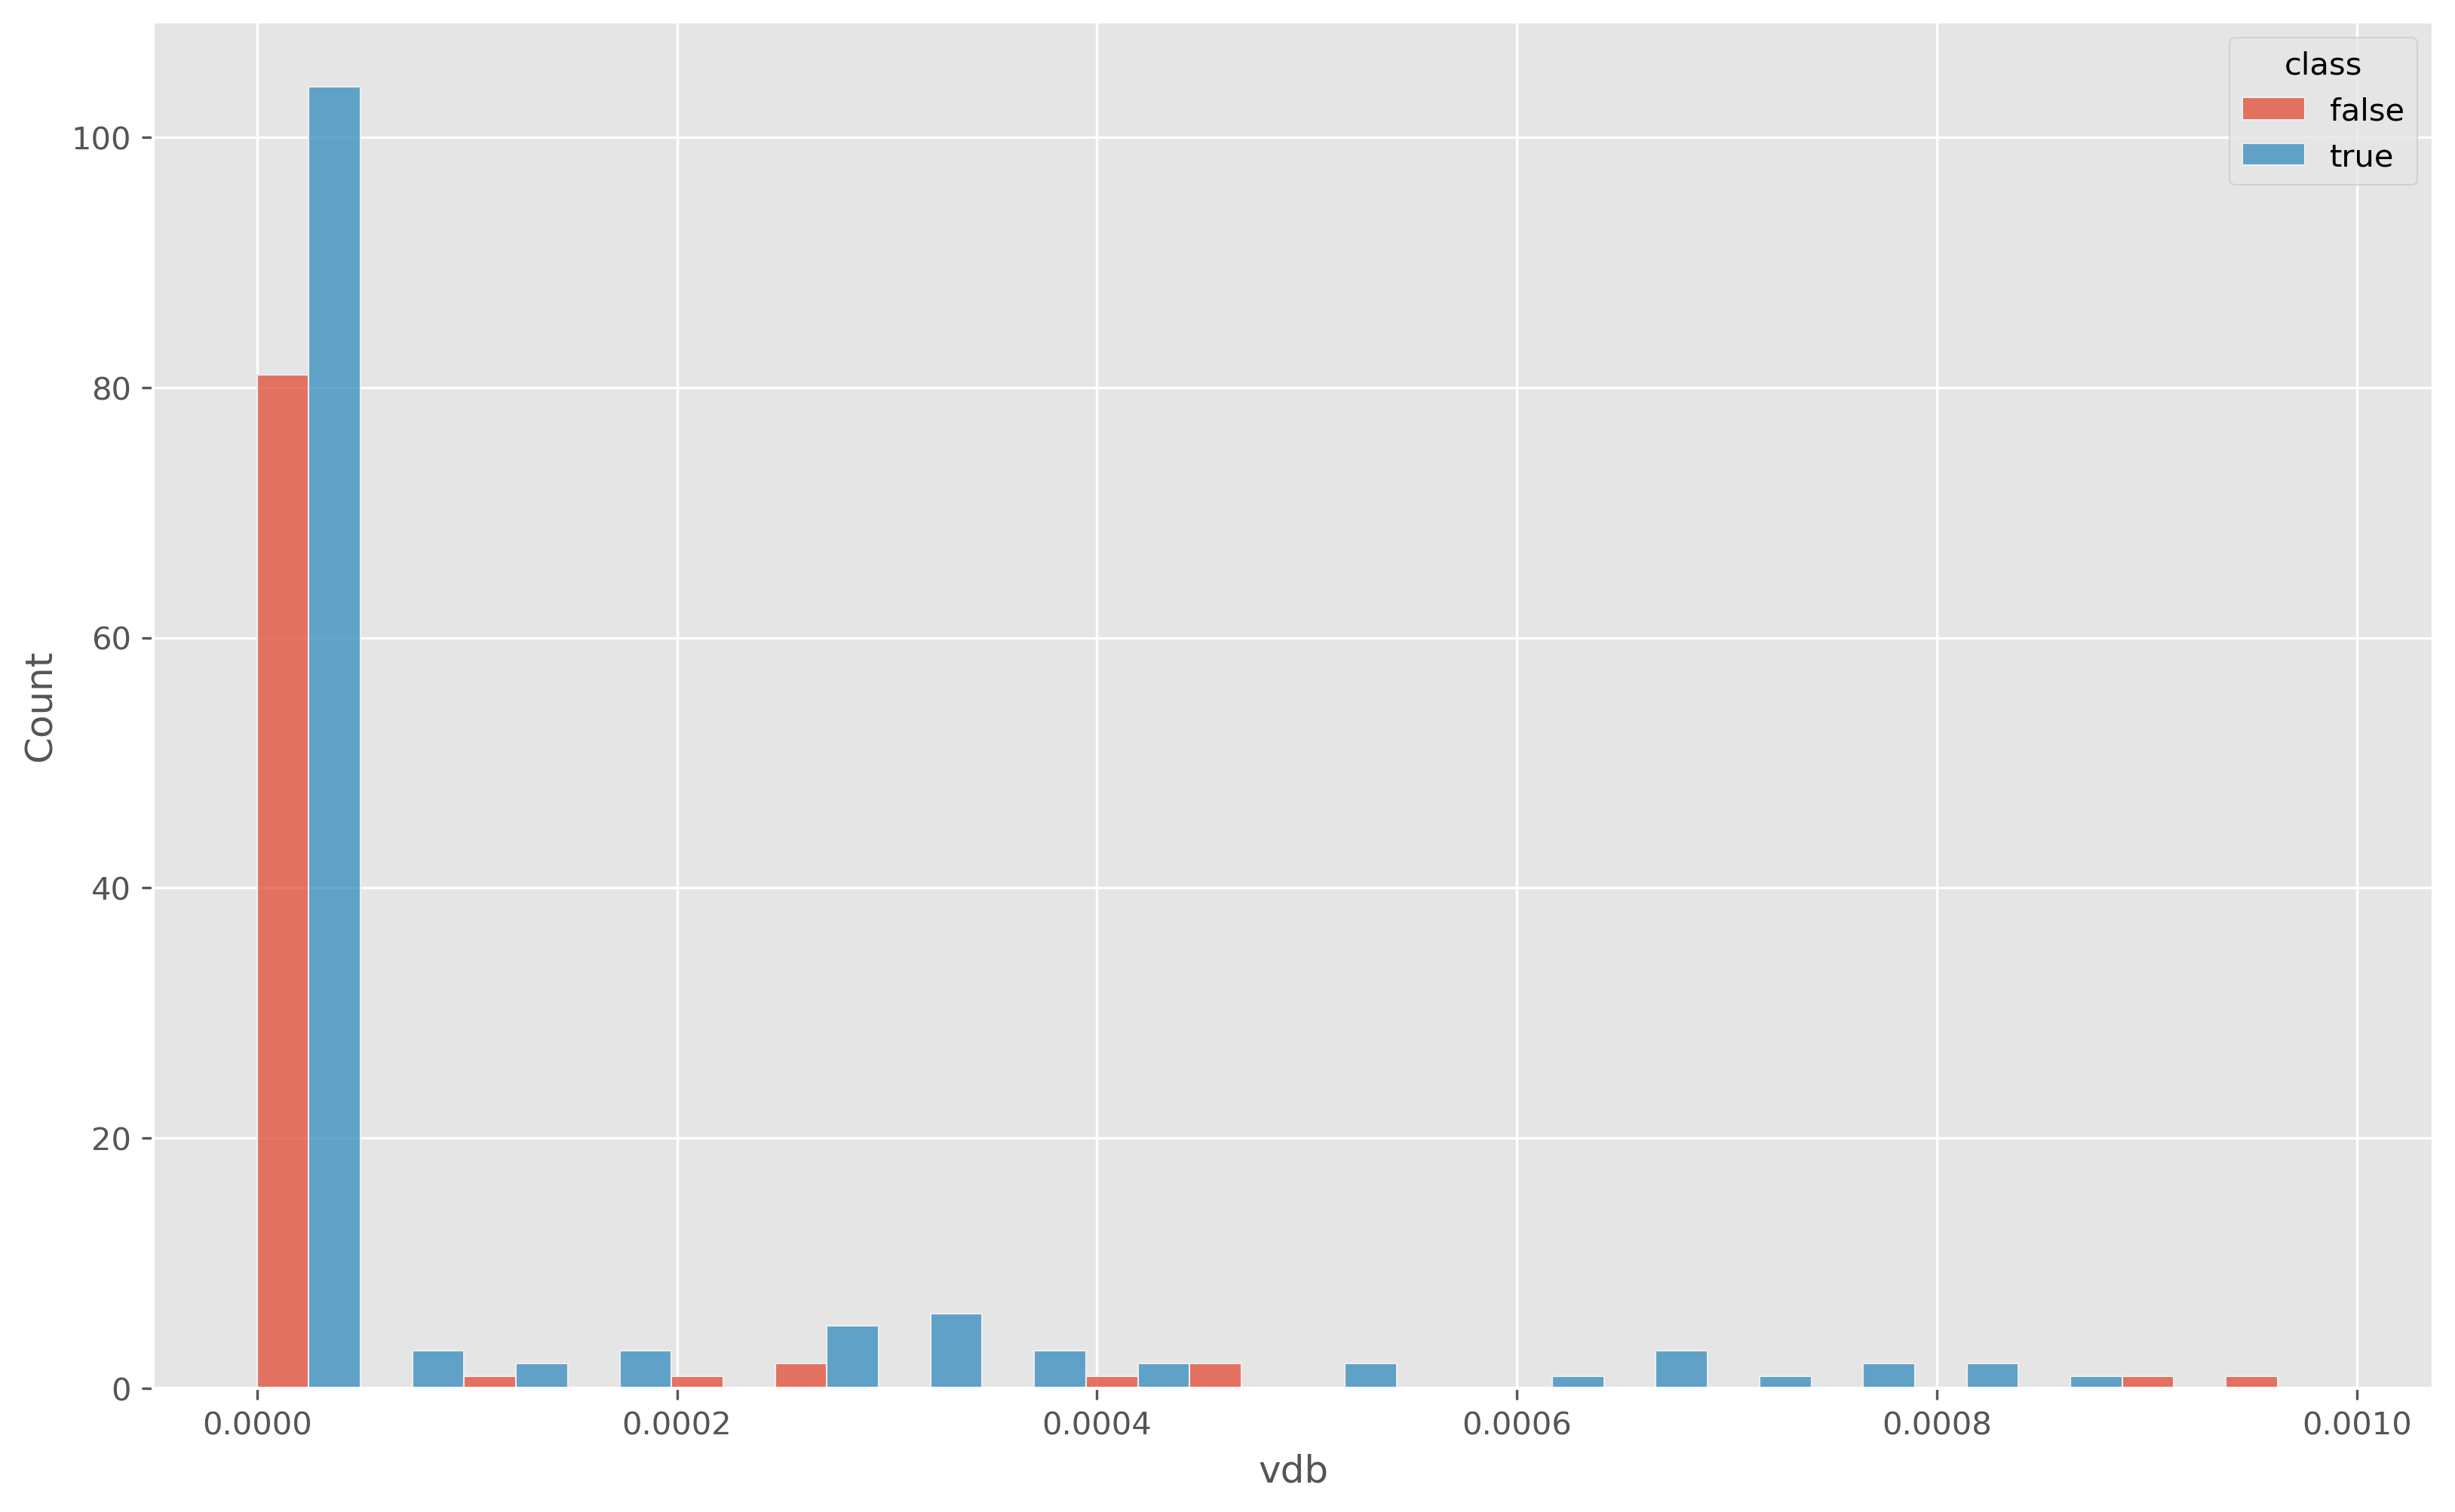

In [82]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df.query("vdb<1e-3"), x="vdb", hue="class", multiple="dodge", bins=20)
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 0.0001))

In [50]:
ts = []
fs = []
for i in range(1, 30):
    v = 1 * 10**(-i)
    f, t = df.query("vdb<@v").groupby(["class"])["vdb"].count()
    fs.append(f)
    ts.append(t)

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

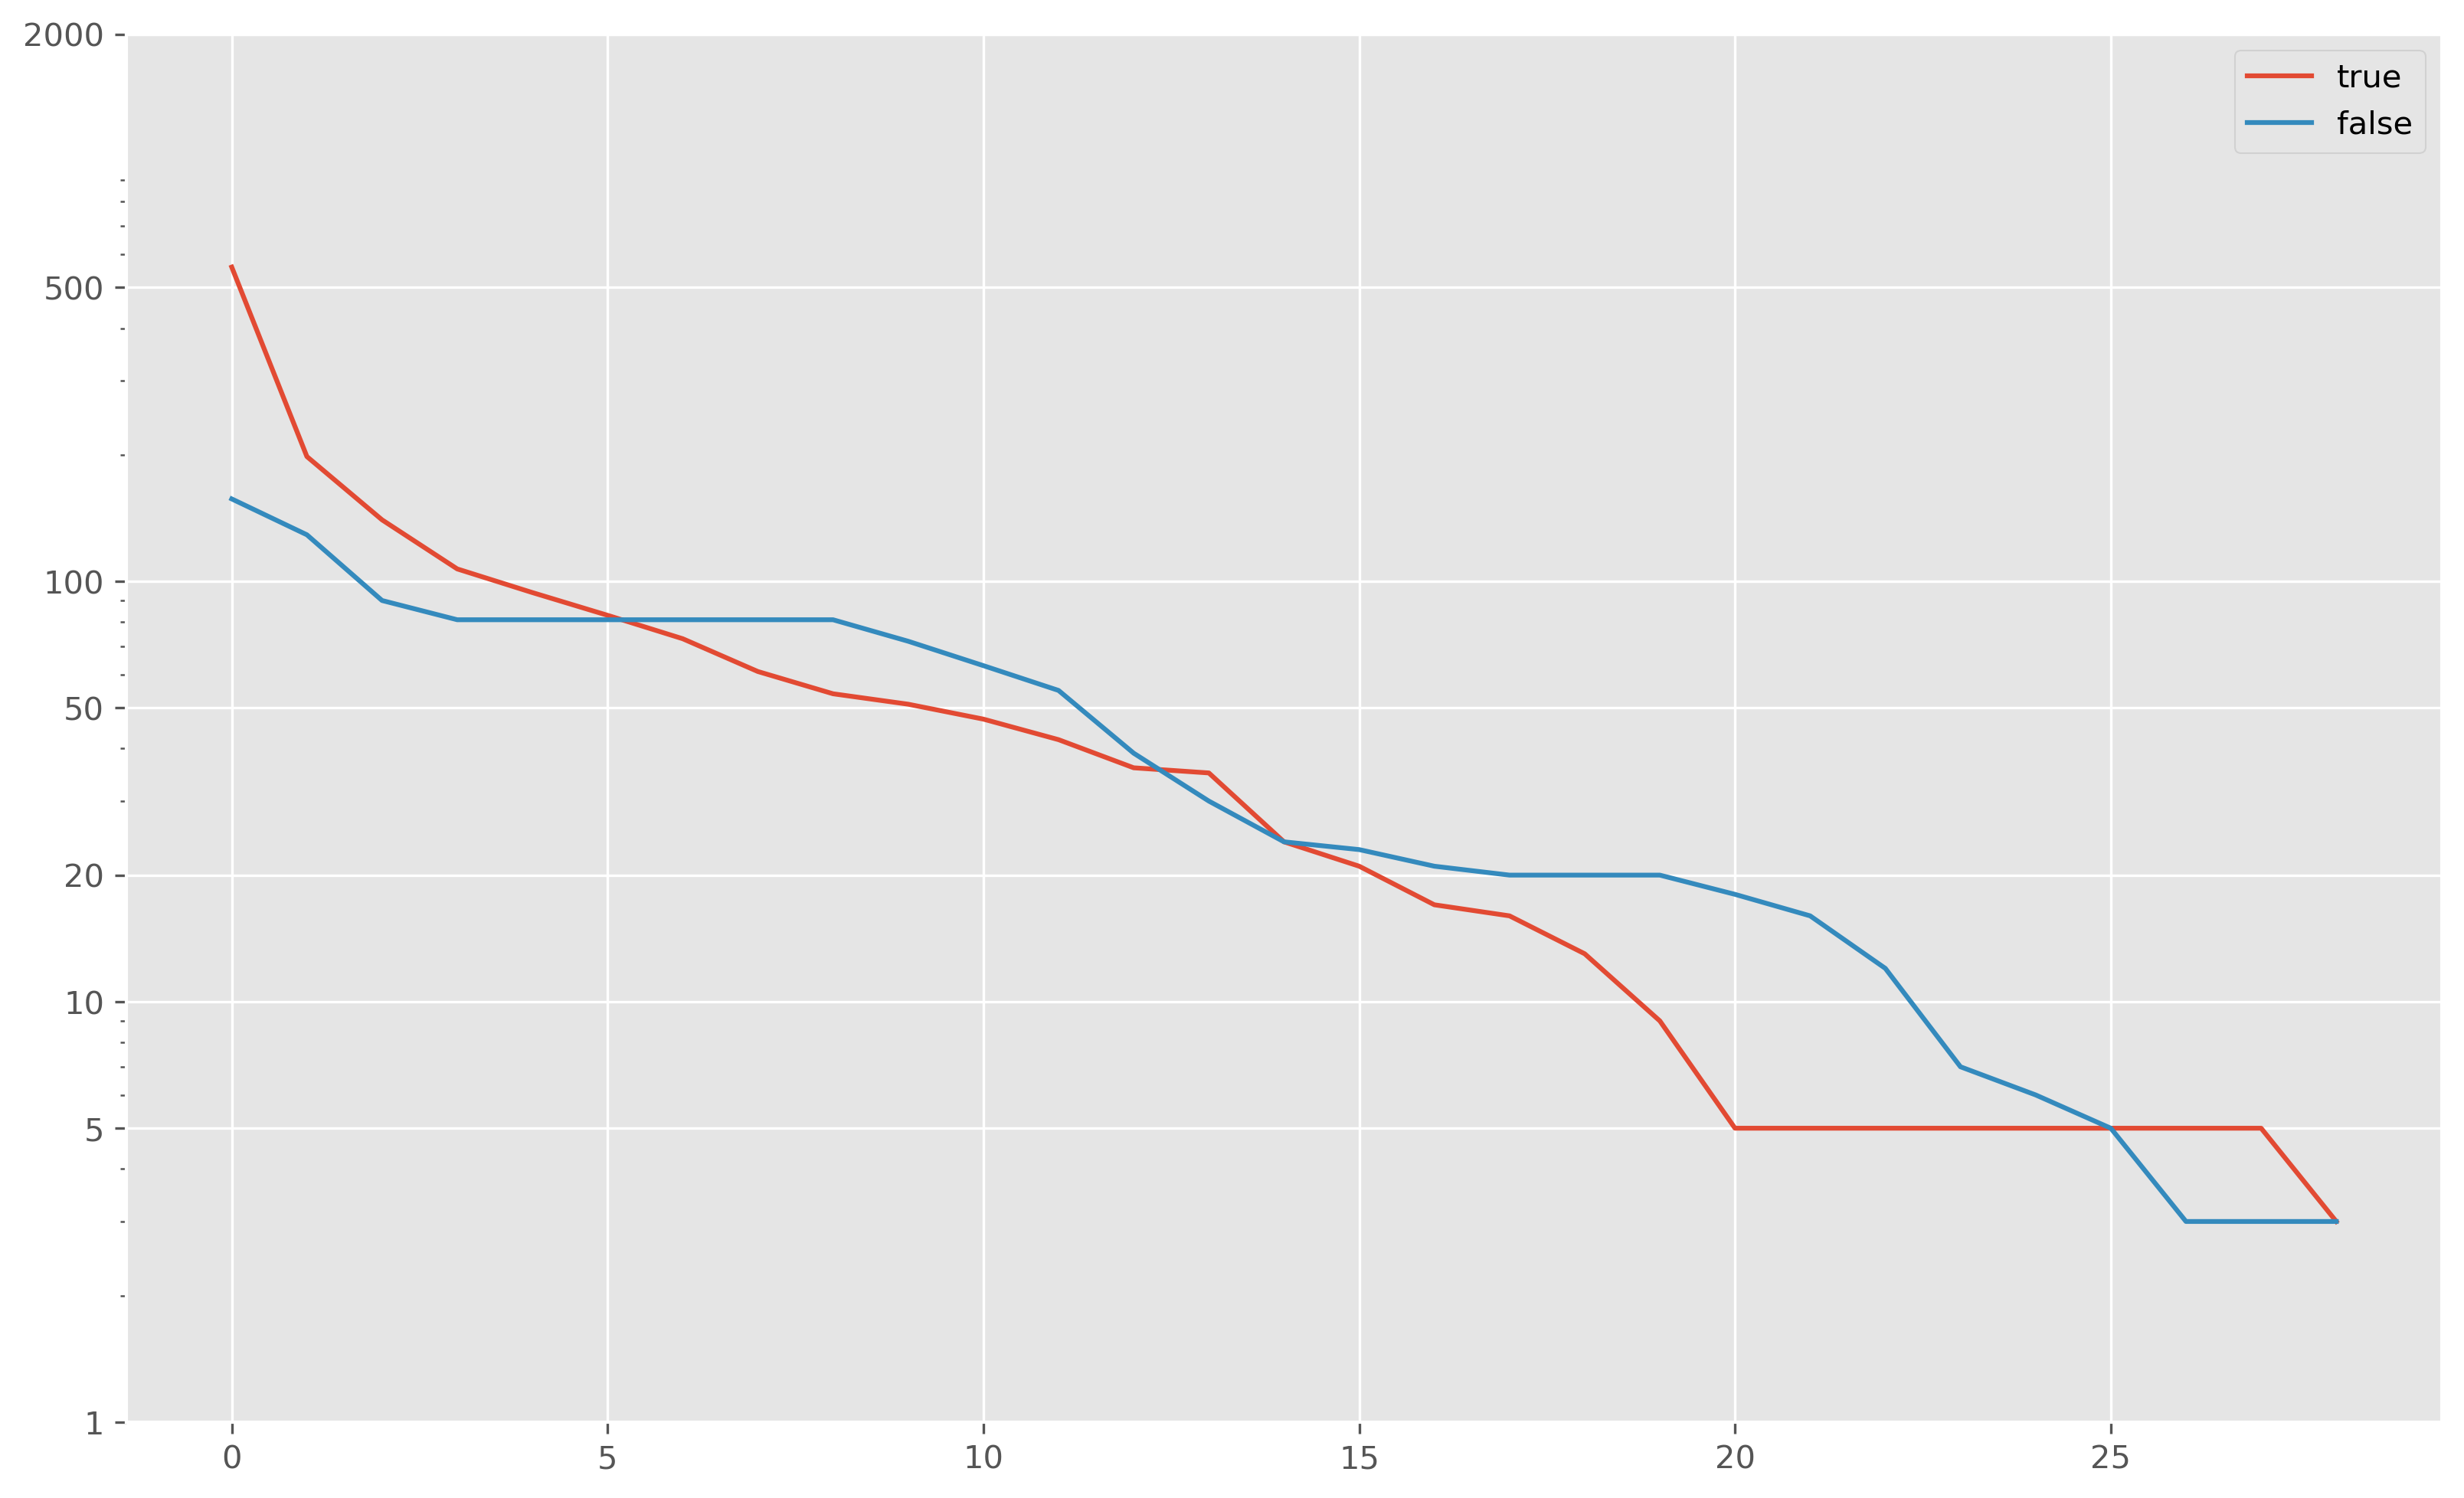

In [51]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ts, label="true")
ax.plot(fs, label="false")
ax.legend()
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)

In [52]:
ratios = []
for x, y in zip(ts, fs):
    total = x+y
    r = y/total
    ratios.append(r)

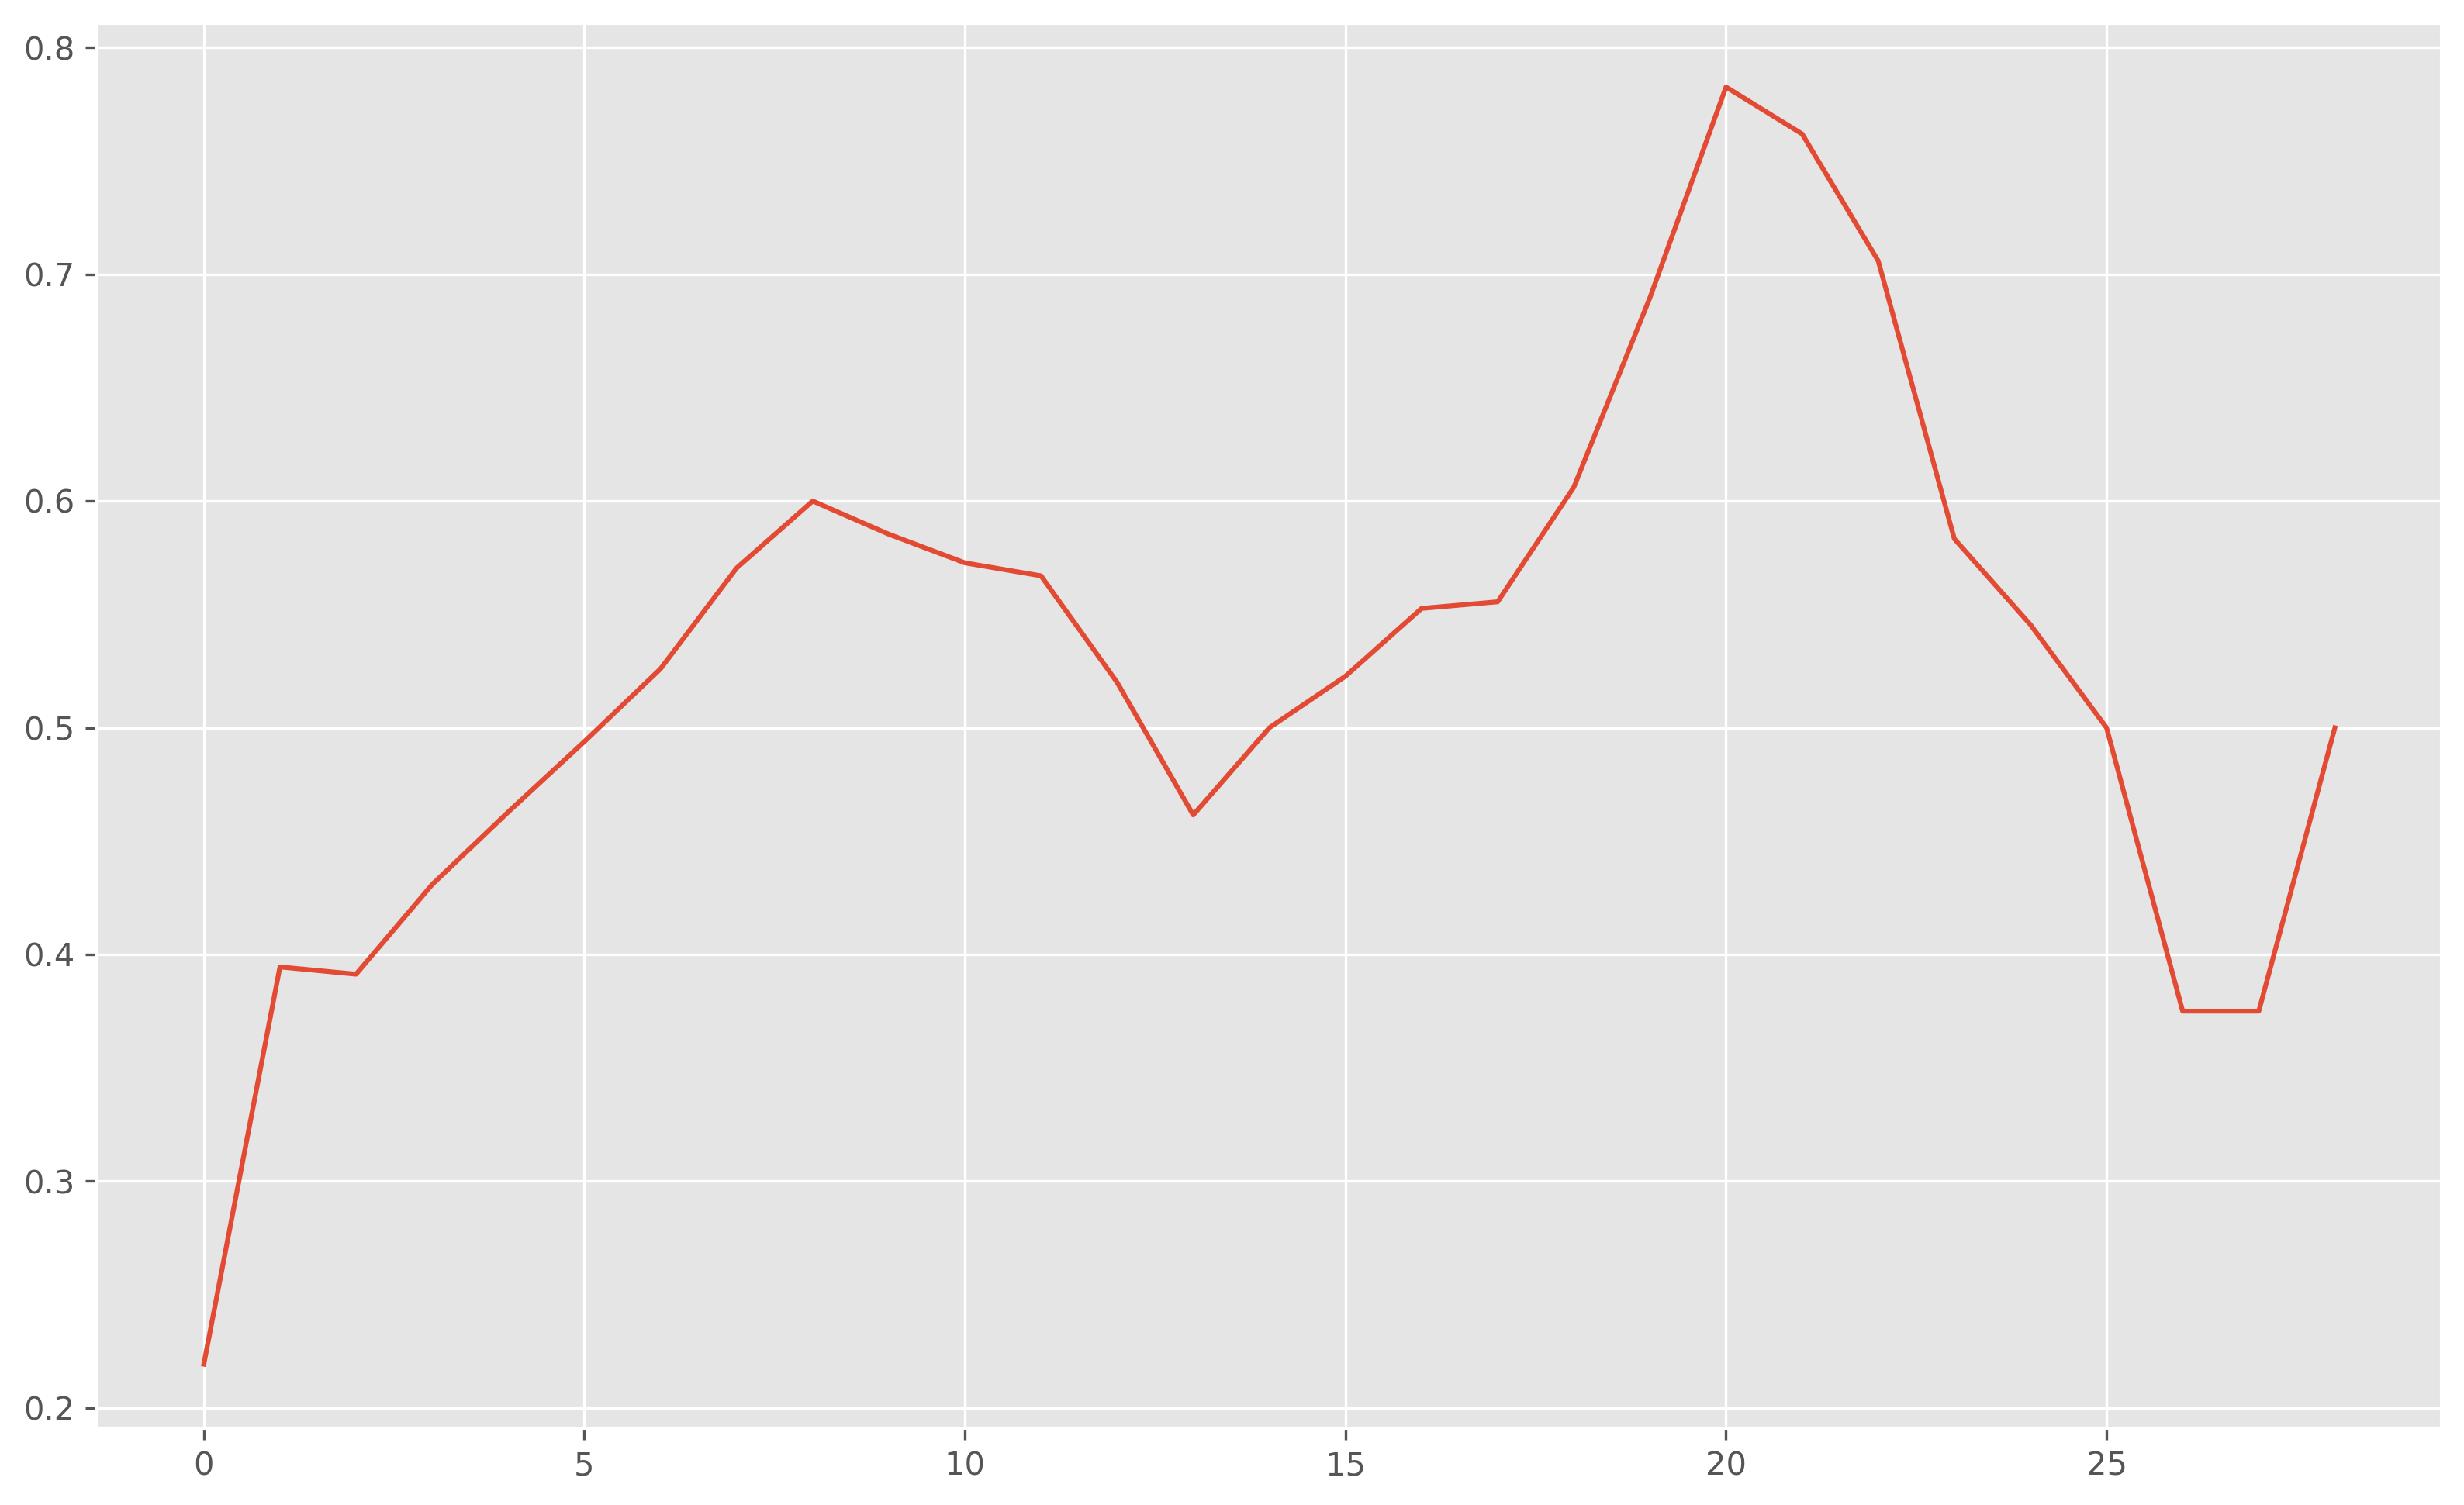

In [53]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ax.plot(ratios)
# ax.legend()
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

In [54]:
ratios[15]

0.5227272727272727

In [55]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         true = isec_dir / f"{s}/0003.vcf"
#         true_out = stats_dir / f"{s}.true.mqsbz"
#         false = isec_dir / f"{s}/0001.vcf"
#         false_out = stats_dir / f"{s}.false.mqsbz"
#         opts = f"-i 'TYPE=\"SNP\"' -f '%MQSBZ\n'"
#         jobs.append((true, true_out, opts))
#         jobs.append((false, false_out, opts))
#     pool.starmap(bcftools_query, jobs)

In [37]:
mqsbz = []
for s in samples:
    mqsbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.false.mqsbz").read().splitlines() if x])
    mqsbz.extend([None if x=="." else float(x) for x in open(stats_dir / f"{s}.true.mqsbz").read().splitlines() if x])

df["mqsbz"] = mqsbz

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 500, '500'),
 Text(0, 2000, '2000')]

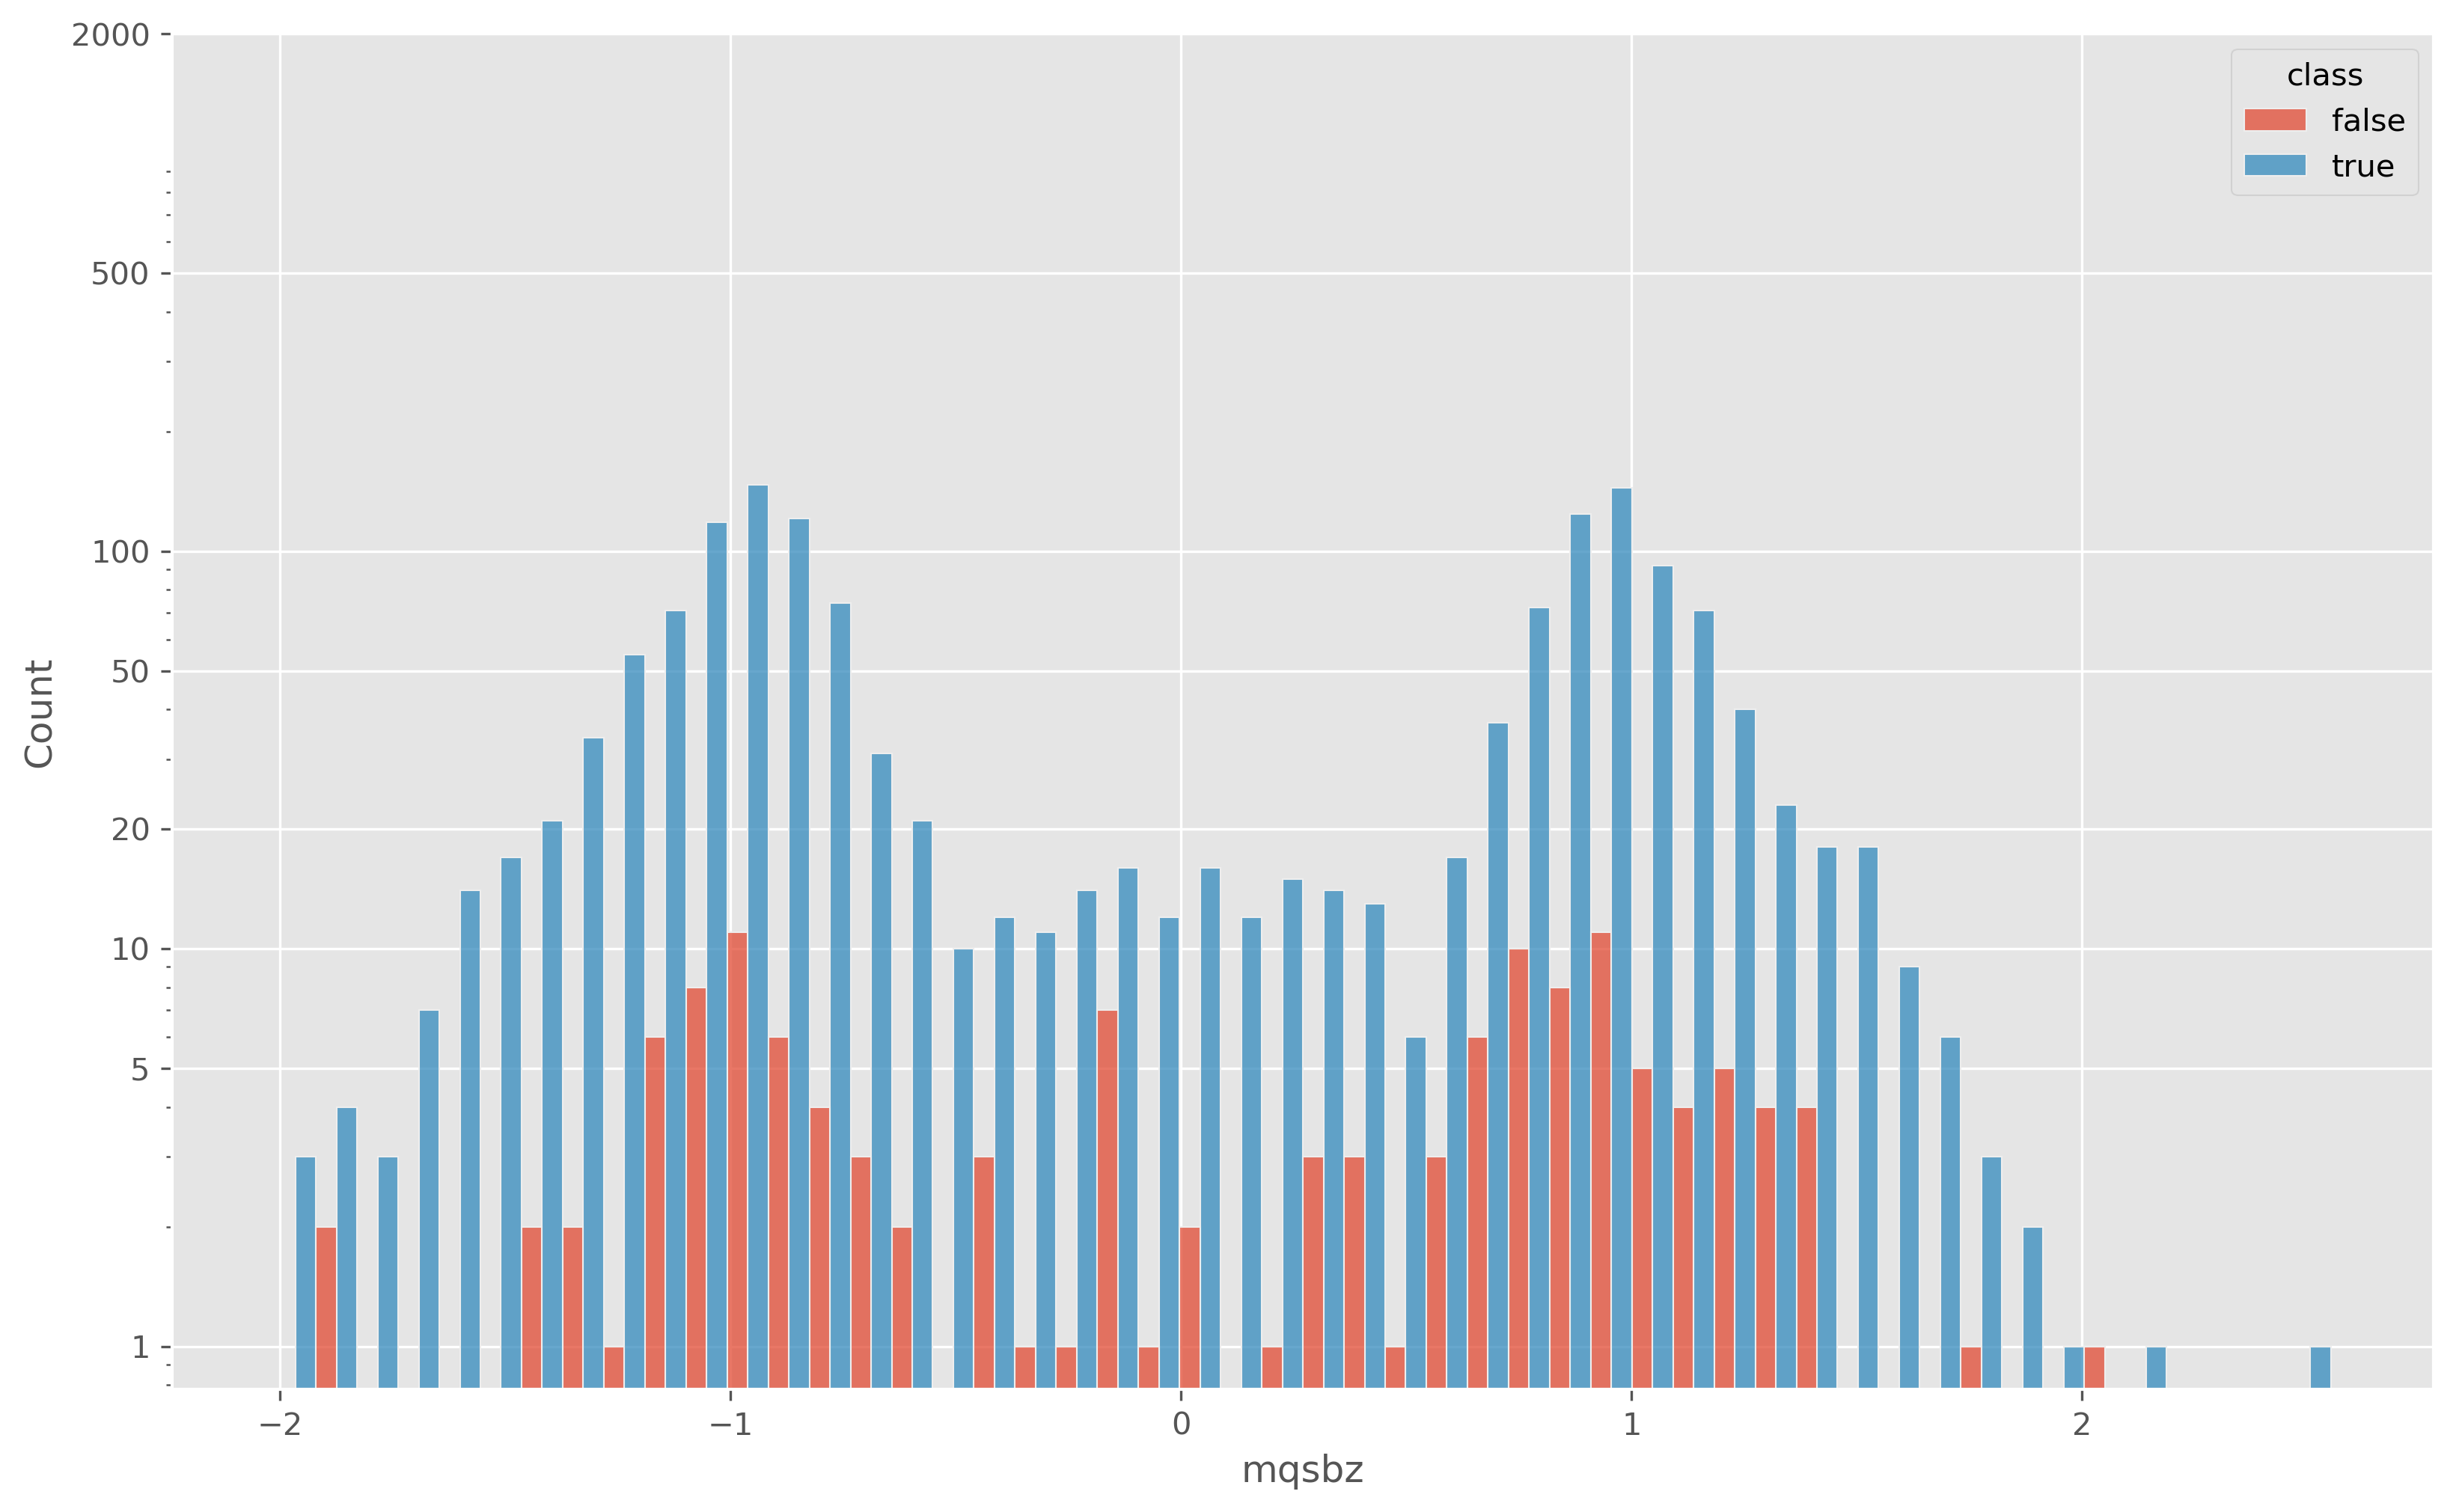

In [84]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="mqsbz", hue="class", multiple="dodge", bins=50)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 100))

In [38]:
df["iscbz"] = df.apply(lambda r: r.rpbz*r.vdb, axis=1)

[Text(0, 1, '1'),
 Text(0, 5, '5'),
 Text(0, 10, '10'),
 Text(0, 20, '20'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 1000, '1000')]

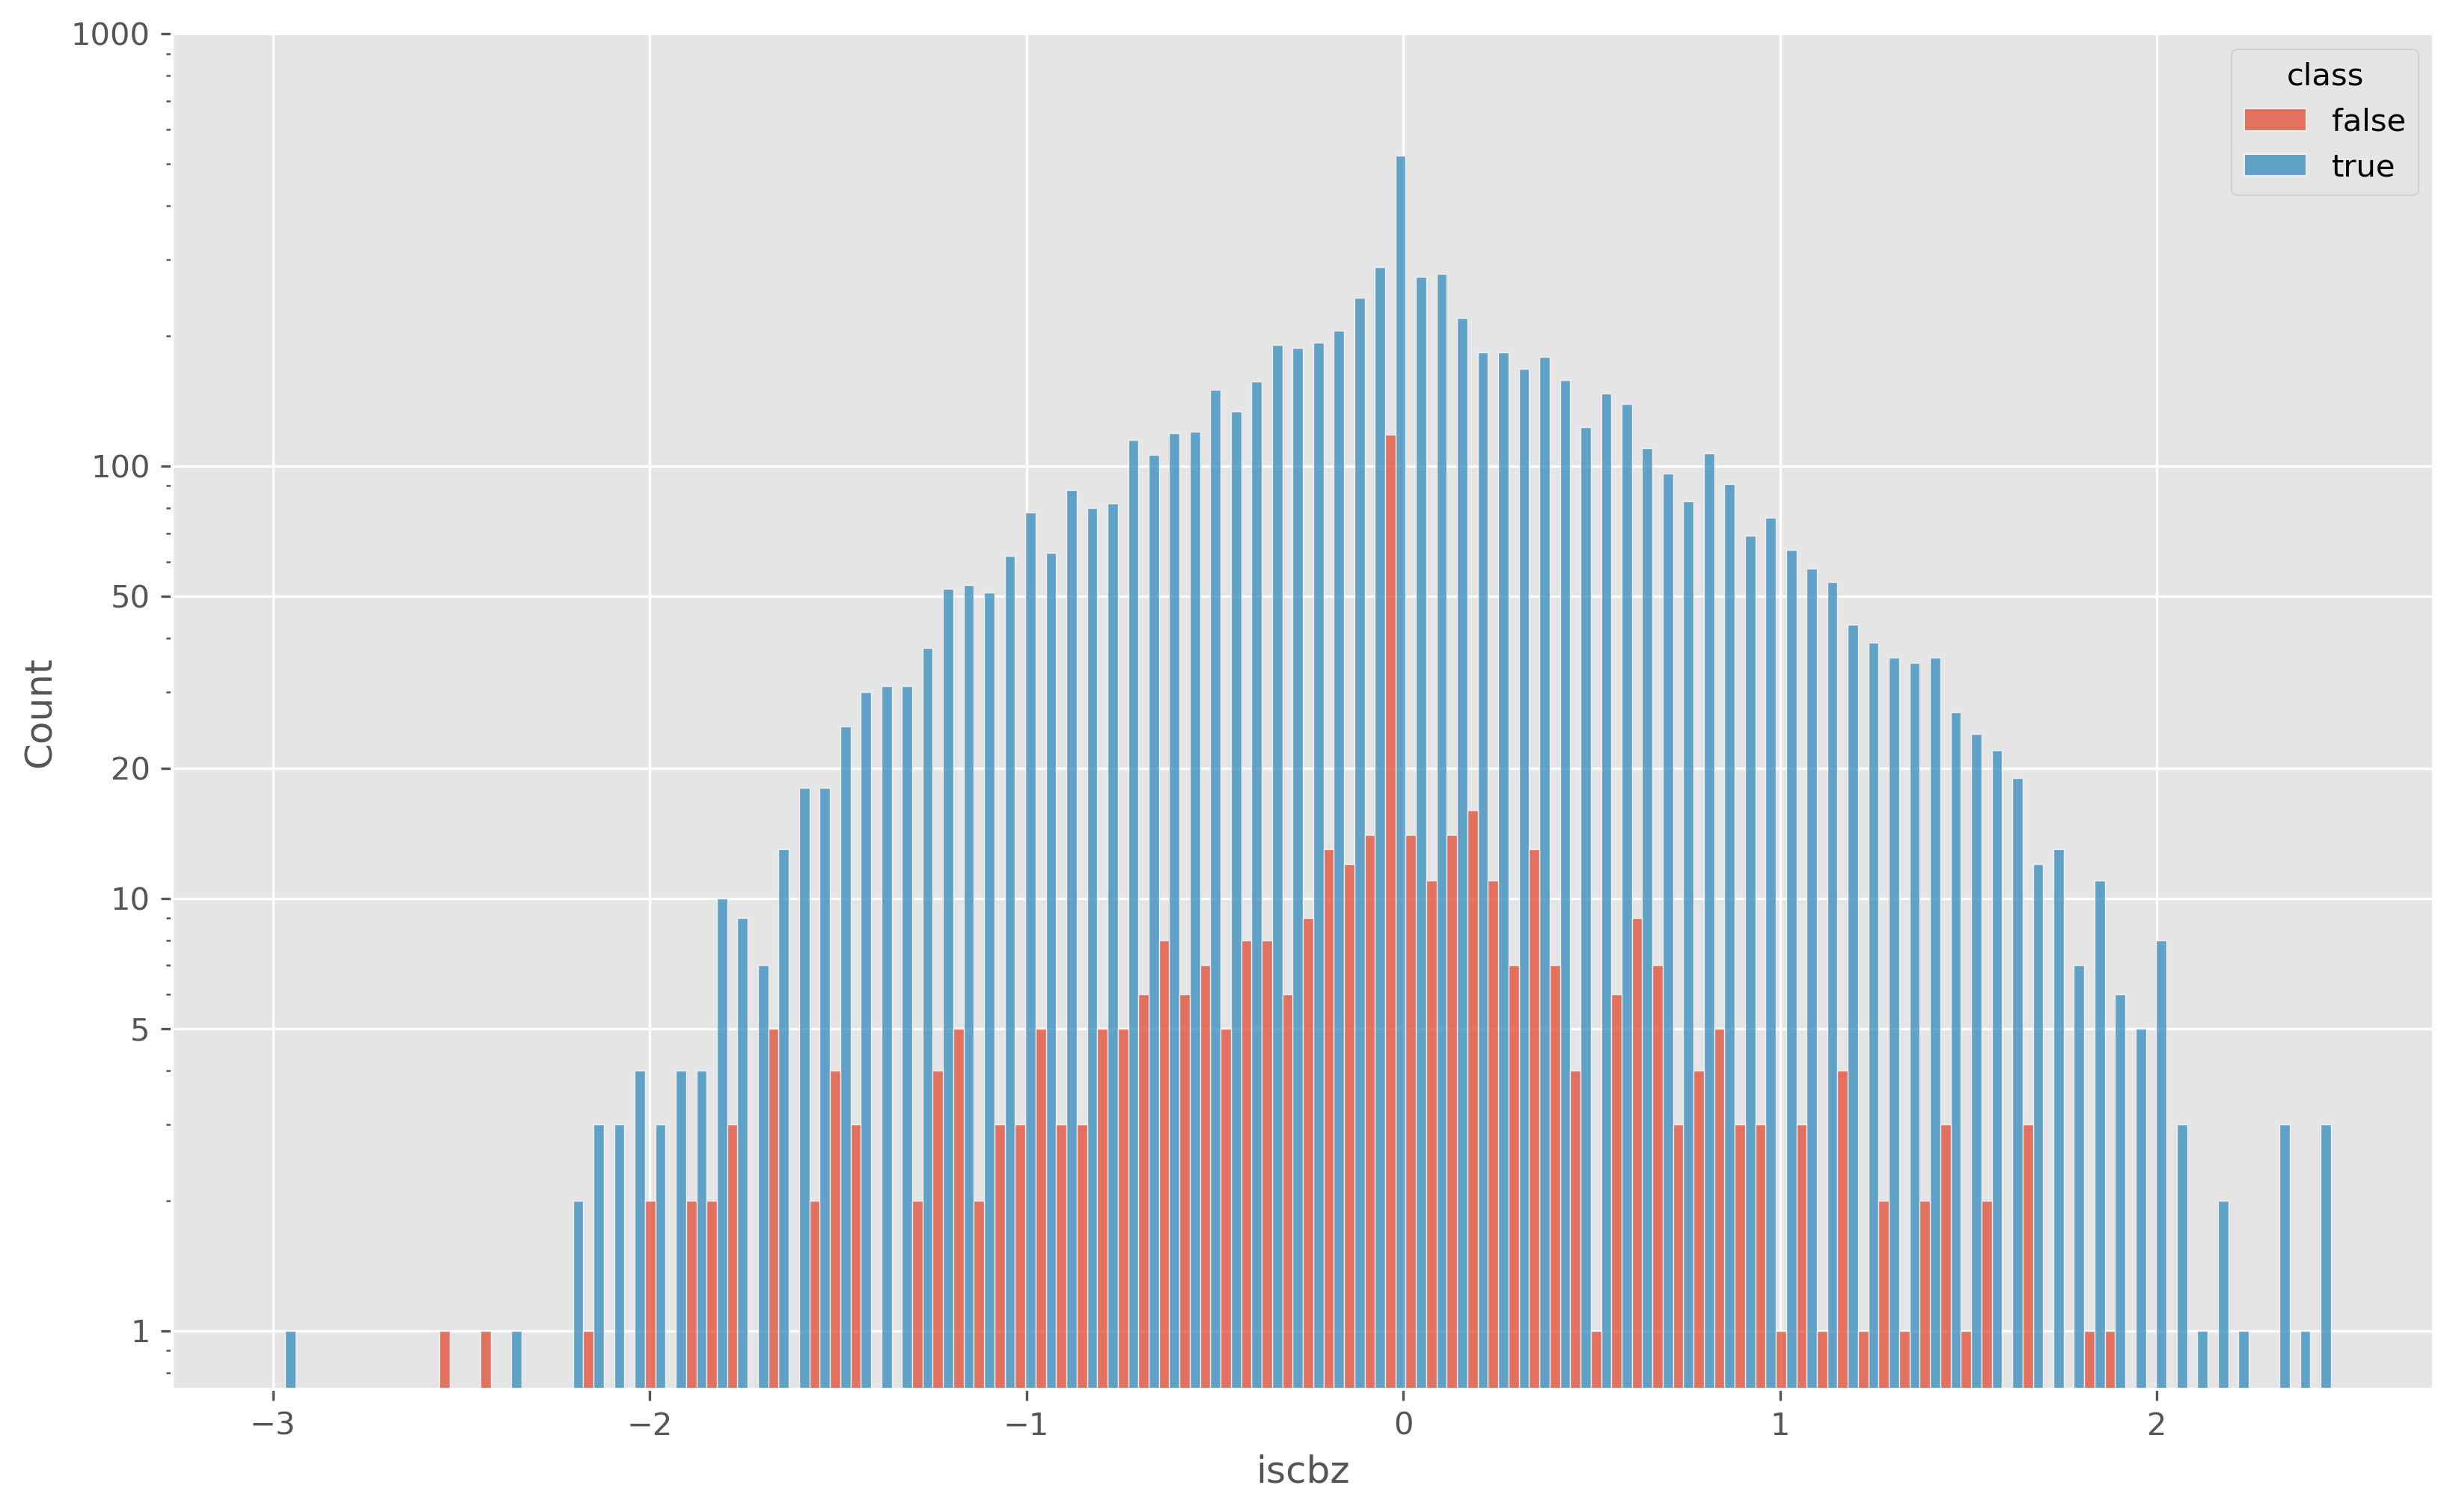

In [114]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
sns.histplot(data=df, x="iscbz", hue="class", multiple="dodge", bins=100)
ax.set_yscale("log")
ylabels = [1, 5, 10, 20, 50, 100, 1000]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels)
# ax.set_xlim((0, 30))

In [39]:
# ratios = []
# for i in range(0, 10):
#     f, t = df.query("iscbz>@i").groupby(["class"])["iscbz"].count()
#     total = f+t
#     r = f/total
#     ratios.append(r)


In [ ]:
# fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
# ax.plot(ratios)
# ax.legend()
# ax.set_yscale("log")
# ylabels = [1, 5, 10, 20, 50, 100, 500, 2000]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

In [40]:
def bcftools_filter(vcf, output, opts):
    !bcftools view {opts} -o {output} {vcf}

In [41]:
filter_dir = Path("filter")
filter_dir.mkdir(exist_ok=True)

In [118]:
min_qual = 60
max_scbz = 5
max_scr = 170

# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         query = call_dir / f"{s}.calls.vcf.gz"
#         output = filter_dir / f"{s}.filter.bcf"
#         opts = f"-Ob -e 'QUAL < {min_qual} || SCBZ > {max_scbz} || SCR > {max_scr}'"
#         jobs.append((query, output, opts))
#     pool.starmap(bcftools_filter, jobs)

In [119]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         vcf = filter_dir / f"{s}.filter.bcf"
#         opts = ""
#         jobs.append((vcf, opts))
#     pool.starmap(bcftools_index, jobs)

Run hap.py for filtered data

In [42]:
eval_dir = Path("eval")
eval_dir.mkdir(exist_ok=True)

In [43]:
def happy(truth, query, ref, opts):
    uri = "docker://quay.io/biocontainers/hap.py:0.3.14--py27h5c5a3ab_0"
    !singularity exec {uri} hap.py {opts} -r {ref} {truth} {query}

In [120]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = filter_dir / f"{s}.filter.bcf"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.filter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

INFO:    Using cached SIF image
2021-09-25 02:31:02,208 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
Hap.py 
[I] Total VCF records:         1868
[I] Non-reference VCF records: 1868
[I] Total VCF records:         1546841
[I] Non-reference VCF records: 1886
Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          139         0       139            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          139         0       139            0         0          0      0      0  

2021-09-25 02:32:10,043 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
Hap.py 
[I] Total VCF records:         2940
[I] Non-reference VCF records: 2940
[I] Total VCF records:         2070716
[I] Non-reference VCF records: 2034
Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          218         0       218            0         0          0      0      0       0.000000           0.00000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          218         0       218            0         0          0      0      0       0.000000           0.00000 

Run hap.py for unfiltered data

In [121]:
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = call_dir / f"{s}.calls.vcf.gz"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.nofilter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)
        

INFO:    Using cached SIF image
2021-09-25 02:33:41,302 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
Hap.py 
[I] Total VCF records:         1868
[I] Non-reference VCF records: 1868
[I] Total VCF records:         4411148
[I] Non-reference VCF records: 2223
Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          139         0       139            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          139         0       139            0         0          0      0      0  

2021-09-25 02:37:29,044 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
Hap.py 
[I] Total VCF records:         2940
[I] Non-reference VCF records: 2940
[I] Total VCF records:         4403541
[I] Non-reference VCF records: 2321
Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          218         0       218            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          218         0       218            0         0          0      0      0       0.000000          0.000000 

Run hap.py for unfiltered v1.12 data

In [44]:
v112_call_dir = Path("../nanopore/snp_calls/madagascar/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = v112_call_dir / f"{s}.snps.bcf"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.v112.nofilter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

Run hap.py for filtered v1.12 data

In [45]:
v112_filter_dir = Path("../nanopore/filtered_snps/madagascar/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = v112_filter_dir / f"{s}.snps.filtered.bcf"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.v112.filter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

In [46]:
compass_dir = Path("../illumina/gvcfs/")
# with Pool(processes=7) as pool:
#     jobs = []
#     for s in samples:
#         q = compass_dir / f"{s}.compass.vcf.gz"
#         t = truth_dir / f"{s}.truth.vcf.gz"
#         prefix_dir = eval_dir / s
#         prefix_dir.mkdir(exist_ok=True)
#         prefix = prefix_dir / f"{s}.compass.filter"
#         opts = f"--set-gt hom --pass-only --write-vcf --leftshift -o {prefix} -T ^{mask}"
#         jobs.append((t, q, h37rv, opts))
#     pool.starmap(happy, jobs)

Get COMPASS unfiltered by not using `--pass-only`

In [55]:
with Pool(processes=7) as pool:
    jobs = []
    for s in samples:
        q = compass_dir / f"{s}.compass.vcf.gz"
        t = truth_dir / f"{s}.truth.vcf.gz"
        prefix_dir = eval_dir / s
        prefix_dir.mkdir(exist_ok=True)
        prefix = prefix_dir / f"{s}.compass.nofilter"
        opts = f"--set-gt hom --write-vcf --leftshift -o {prefix} -T ^{mask}"
        jobs.append((t, q, h37rv, opts))
    pool.starmap(happy, jobs)

INFO:    Using cached SIF image
INFO:    Using cached SIF image
INFO:    Using cached SIF image
INFO:    Using cached SIF image
INFO:    Using cached SIF image
INFO:    Using cached SIF image
INFO:    Using cached SIF image
2021-09-25 06:25:12,815 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
2021-09-25 06:25:12,815 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
2021-09-25 06:25:12,815 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
2021-09-25 06:25:12,815 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
2021-09-25 06:25:12,815 WARNING  No reference file found at default locations. You can set the envir

2021-09-25 06:26:26,941 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:26,941 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:26,942 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:26,942 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:26,942 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:26,942 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:27,030 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:27,031 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:27,031 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,514 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,515 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:35,515 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:37,134 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,134 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,134 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,134 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,134 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,135 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,135 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,135 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:37,135 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:38,020 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:38,021 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:39,072 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:39,073 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,045 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,046 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,532 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,533 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,533 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:40,533 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:41,548 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:41,549 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          139         0       139            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          139         0       139            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
   SNP    ALL          852       787        65          943       156          0      0     34       0.923709          0.834571             0.0         0.876880                1.687697     

2021-09-25 06:26:42,830 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,830 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,830 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,830 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,831 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,831 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,831 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,831 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:42,831 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:43,351 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:43,352 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,028 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,029 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,029 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,029 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:44,443 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,277 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,342 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:45,397 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:46,011 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,012 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:46,109 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,109 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,109 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,110 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,967 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,968 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:46,968 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "String"
2021-09-25 06:26:47,837 WARNING  [W::bcf_hdr_register_hrec] The type "None" is not supported, assuming "

Benchmarking Summary:
  Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
 INDEL    ALL          140         0       140            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
 INDEL   PASS          140         0       140            0         0          0      0      0       0.000000          0.000000             0.0              NaN                     NaN                     NaN                        0.0                        NaN
   SNP    ALL          864       818        46          943       125          0      0     27       0.946759          0.867444             0.0         0.905368                1.666667     

In [56]:
info = []
for s in samples:
    summaries = Path(eval_dir/s).glob("*summary.csv")
    for csv in summaries:
        sheet = pd.read_csv(csv).query("Type=='SNP' and Filter=='PASS'").to_dict(orient="records")[0]
        if "compass" in csv.name:
            version = "Illumina"
        elif "v112" in csv.name:
            version = "bcftools v1.12"
        else:
            version = "bcftools v1.13"
        filtered = not ("nofilter" in csv.name)
        
        if version == "Illumina" and not filtered:
            d = pd.read_csv(csv).query("Type=='SNP' and Filter=='ALL'").to_dict(orient="records")[0]
            info.append(
            (
                s, version, False, d["TRUTH.TOTAL"], d["TRUTH.TP"], 
                d["TRUTH.FN"], d["QUERY.TOTAL"], d["QUERY.FP"], d["METRIC.Recall"],
                d["METRIC.Precision"], d["METRIC.F1_Score"]
            )
        )
        else:
            info.append(
                (
                    s, version, filtered, sheet["TRUTH.TOTAL"], sheet["TRUTH.TP"], 
                    sheet["TRUTH.FN"], sheet["QUERY.TOTAL"], sheet["QUERY.FP"], sheet["METRIC.Recall"],
                    sheet["METRIC.Precision"], sheet["METRIC.F1_Score"]
                )
            )
        
metrics = pd.DataFrame(
    info, 
    columns=[
        "sample", "version", "filtered", 
        "expected", "TP", "FN", "predicted", 
        "FP", "Recall", "Precision", "F1"
    ]
)

In [57]:
metrics.sort_values(by="version", inplace=True)

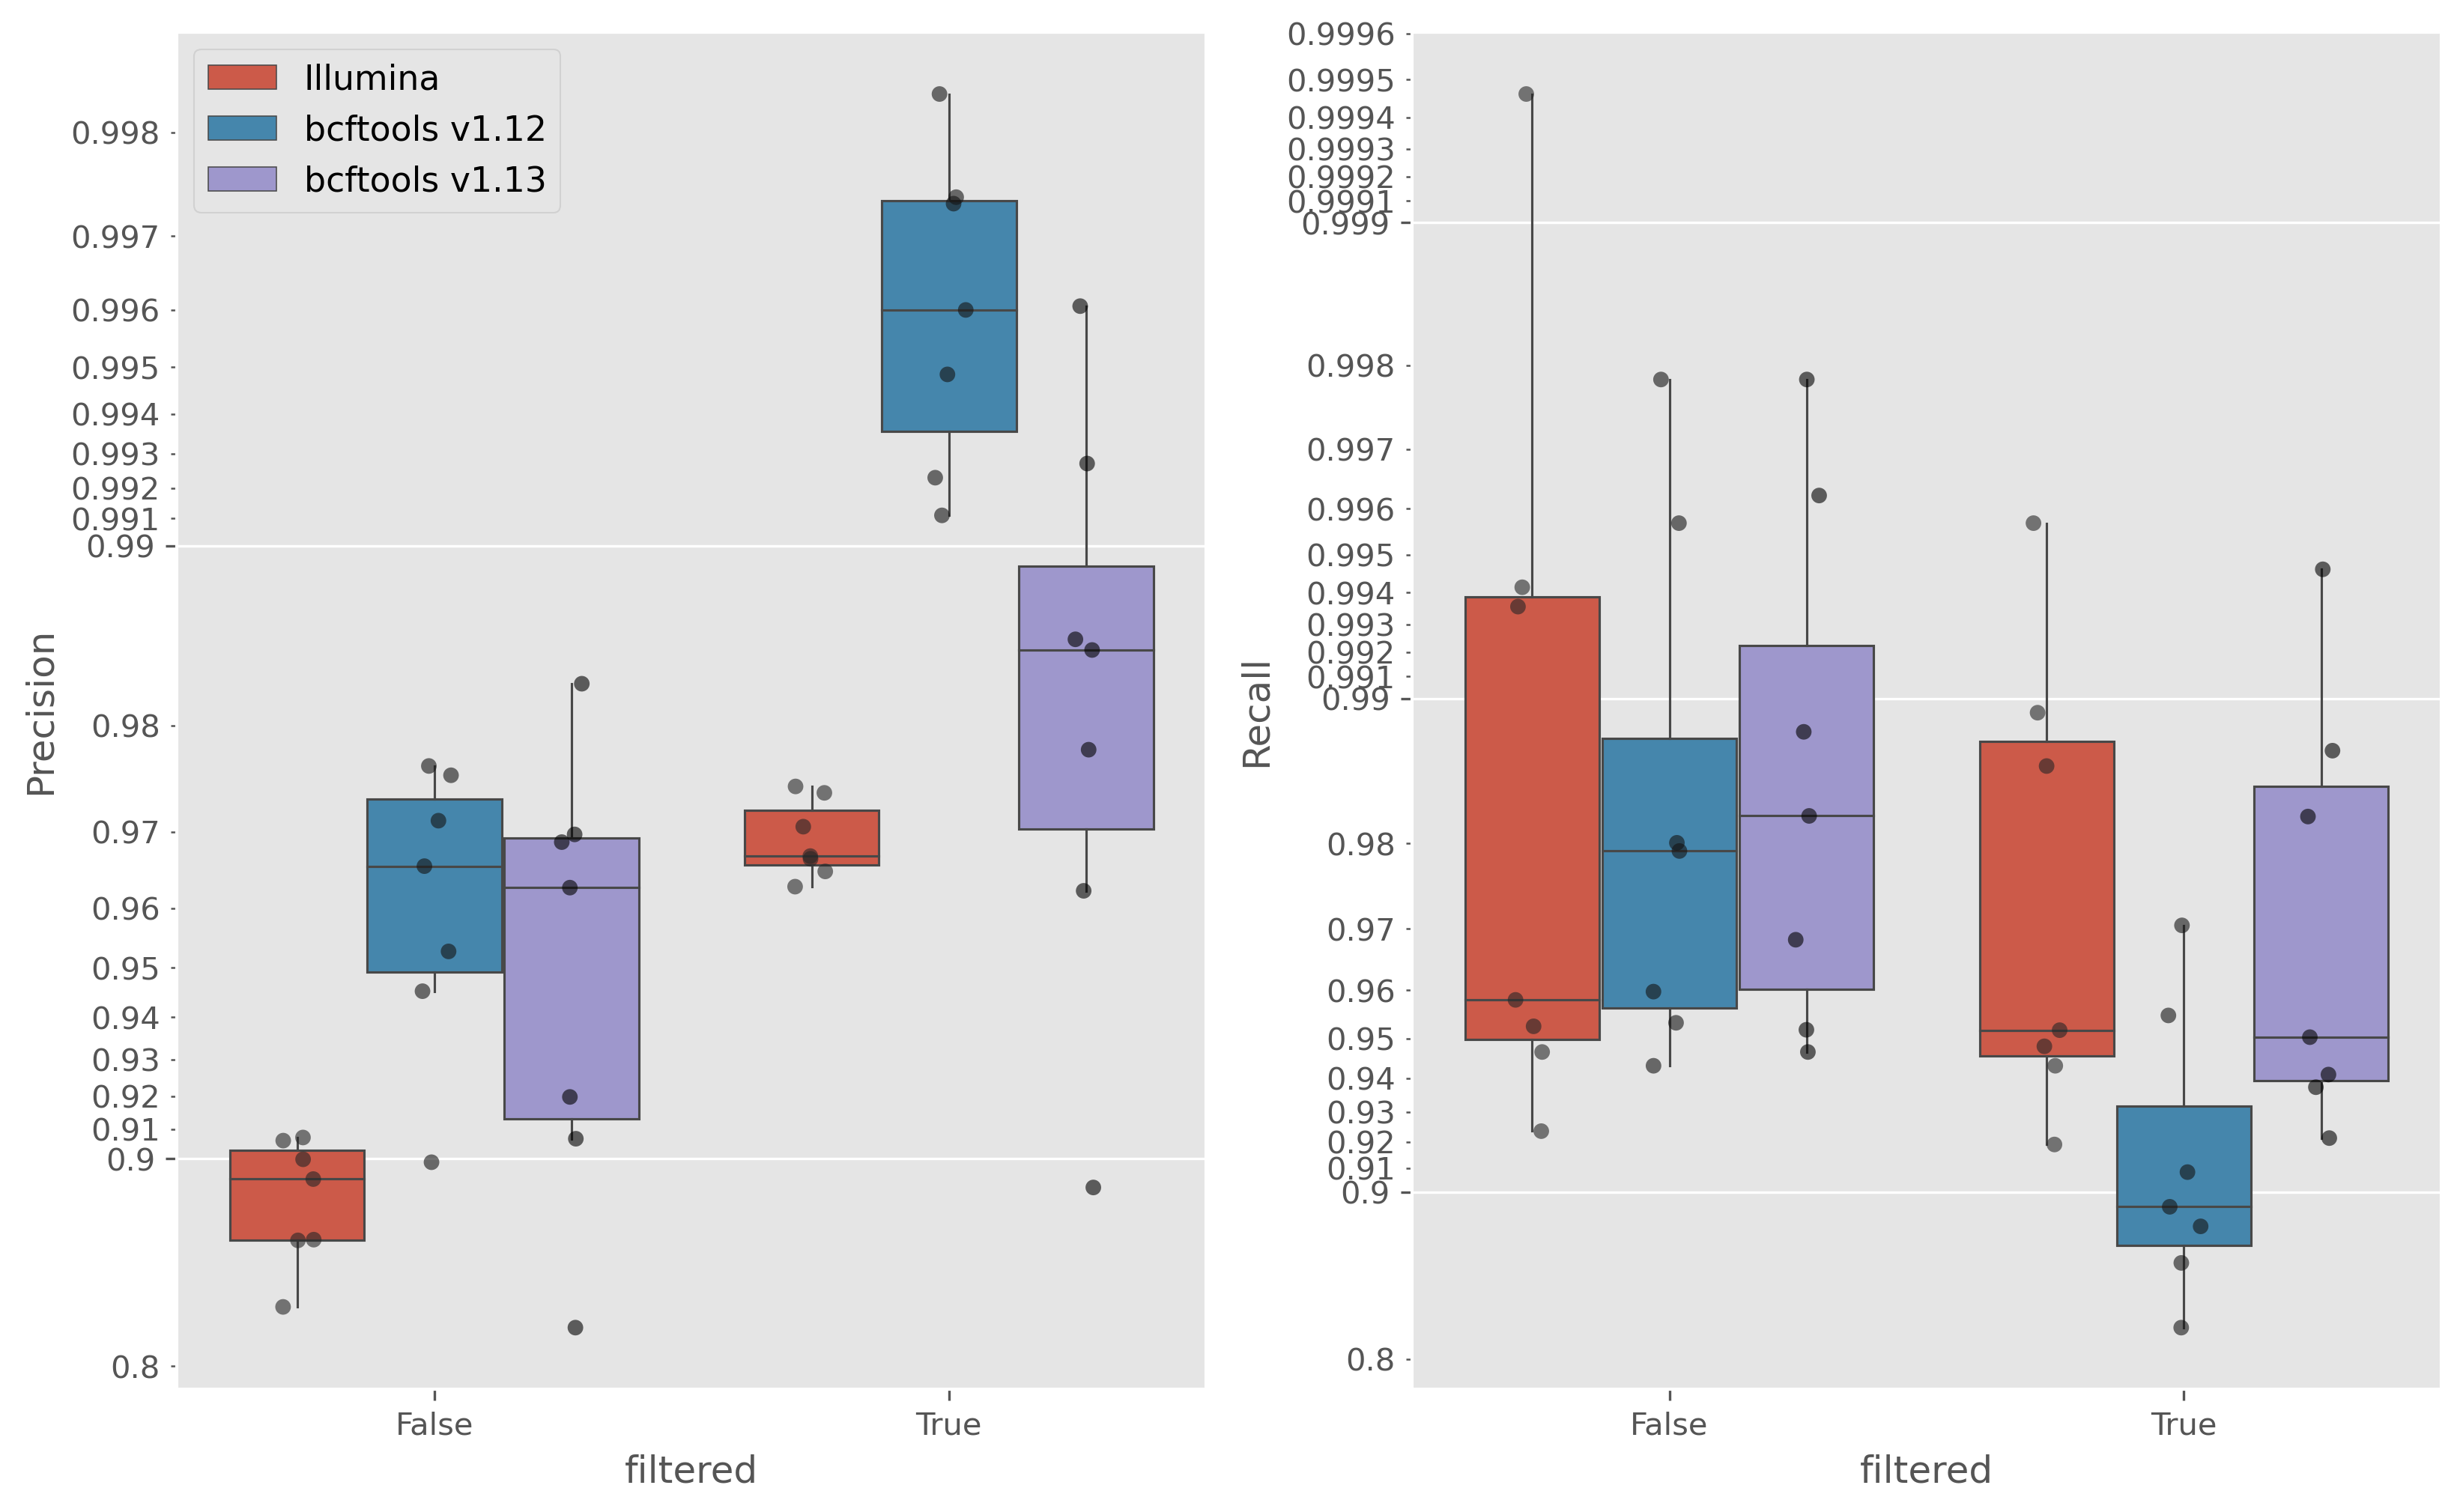

In [193]:
import matplotlib.ticker as ticker
boxprops = dict(linewidth=0.75, fliersize=0, showcaps=False)
stripprops = dict(dodge=True, color="black", alpha=0.6)
fig, axes = plt.subplots(ncols=2, figsize=(13, 8), dpi=300, sharey=False)
axl = axes.flatten()[0]
axr = axes.flatten()[1]
hue = "version"

sns.boxplot(data=metrics, hue=hue, y="Precision", x="filtered", ax=axl, **boxprops)#cut=0)
sns.stripplot(data=metrics, hue=hue, y="Precision", x="filtered", ax=axl, **stripprops)
sns.boxplot(data=metrics, hue=hue, y="Recall", x="filtered", ax=axr, **boxprops)
sns.stripplot(data=metrics, hue=hue, y="Recall", x="filtered", ax=axr, **stripprops)
axl.set_yscale("logit")
axr.set_yscale("logit")

axr.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axr.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axl.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axl.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ylabels = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.990, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 0.9995]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)

# axes.yaxis.set_major_locator(ticker.LogitLocator([0.8, 0.91, 0.991], nbins=1000))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ylabs = []

# for tlab in ax.get_yticklabels():
#     x, y = tlab.get_position()
#     break
#     if y in ylabels:
#         tlab.set(fontsize="2")
#     ylabs.append(tlab)
    
# ax.set_yticklabels(ylabs)

# leghandles, leglabels = ax.get_legend_handles_labels()
# ax.legend(leghandles[:3], leglabels[:3], loc="upper right", prop={"size": 11})
# _ = plt.yticks(fontsize="9")
# ax.set_yscale("logit")
# ylabels = [0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.990, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
# ax.set_yticks(ylabels)
# ax.set_yticklabels(ylabels)
# # ax.set_xlim((0, 30))
leghandles, leglabels = axl.get_legend_handles_labels()
axl.legend(leghandles[:3], leglabels[:3], loc="upper left", prop={"size": 11})
axr.get_legend().remove()

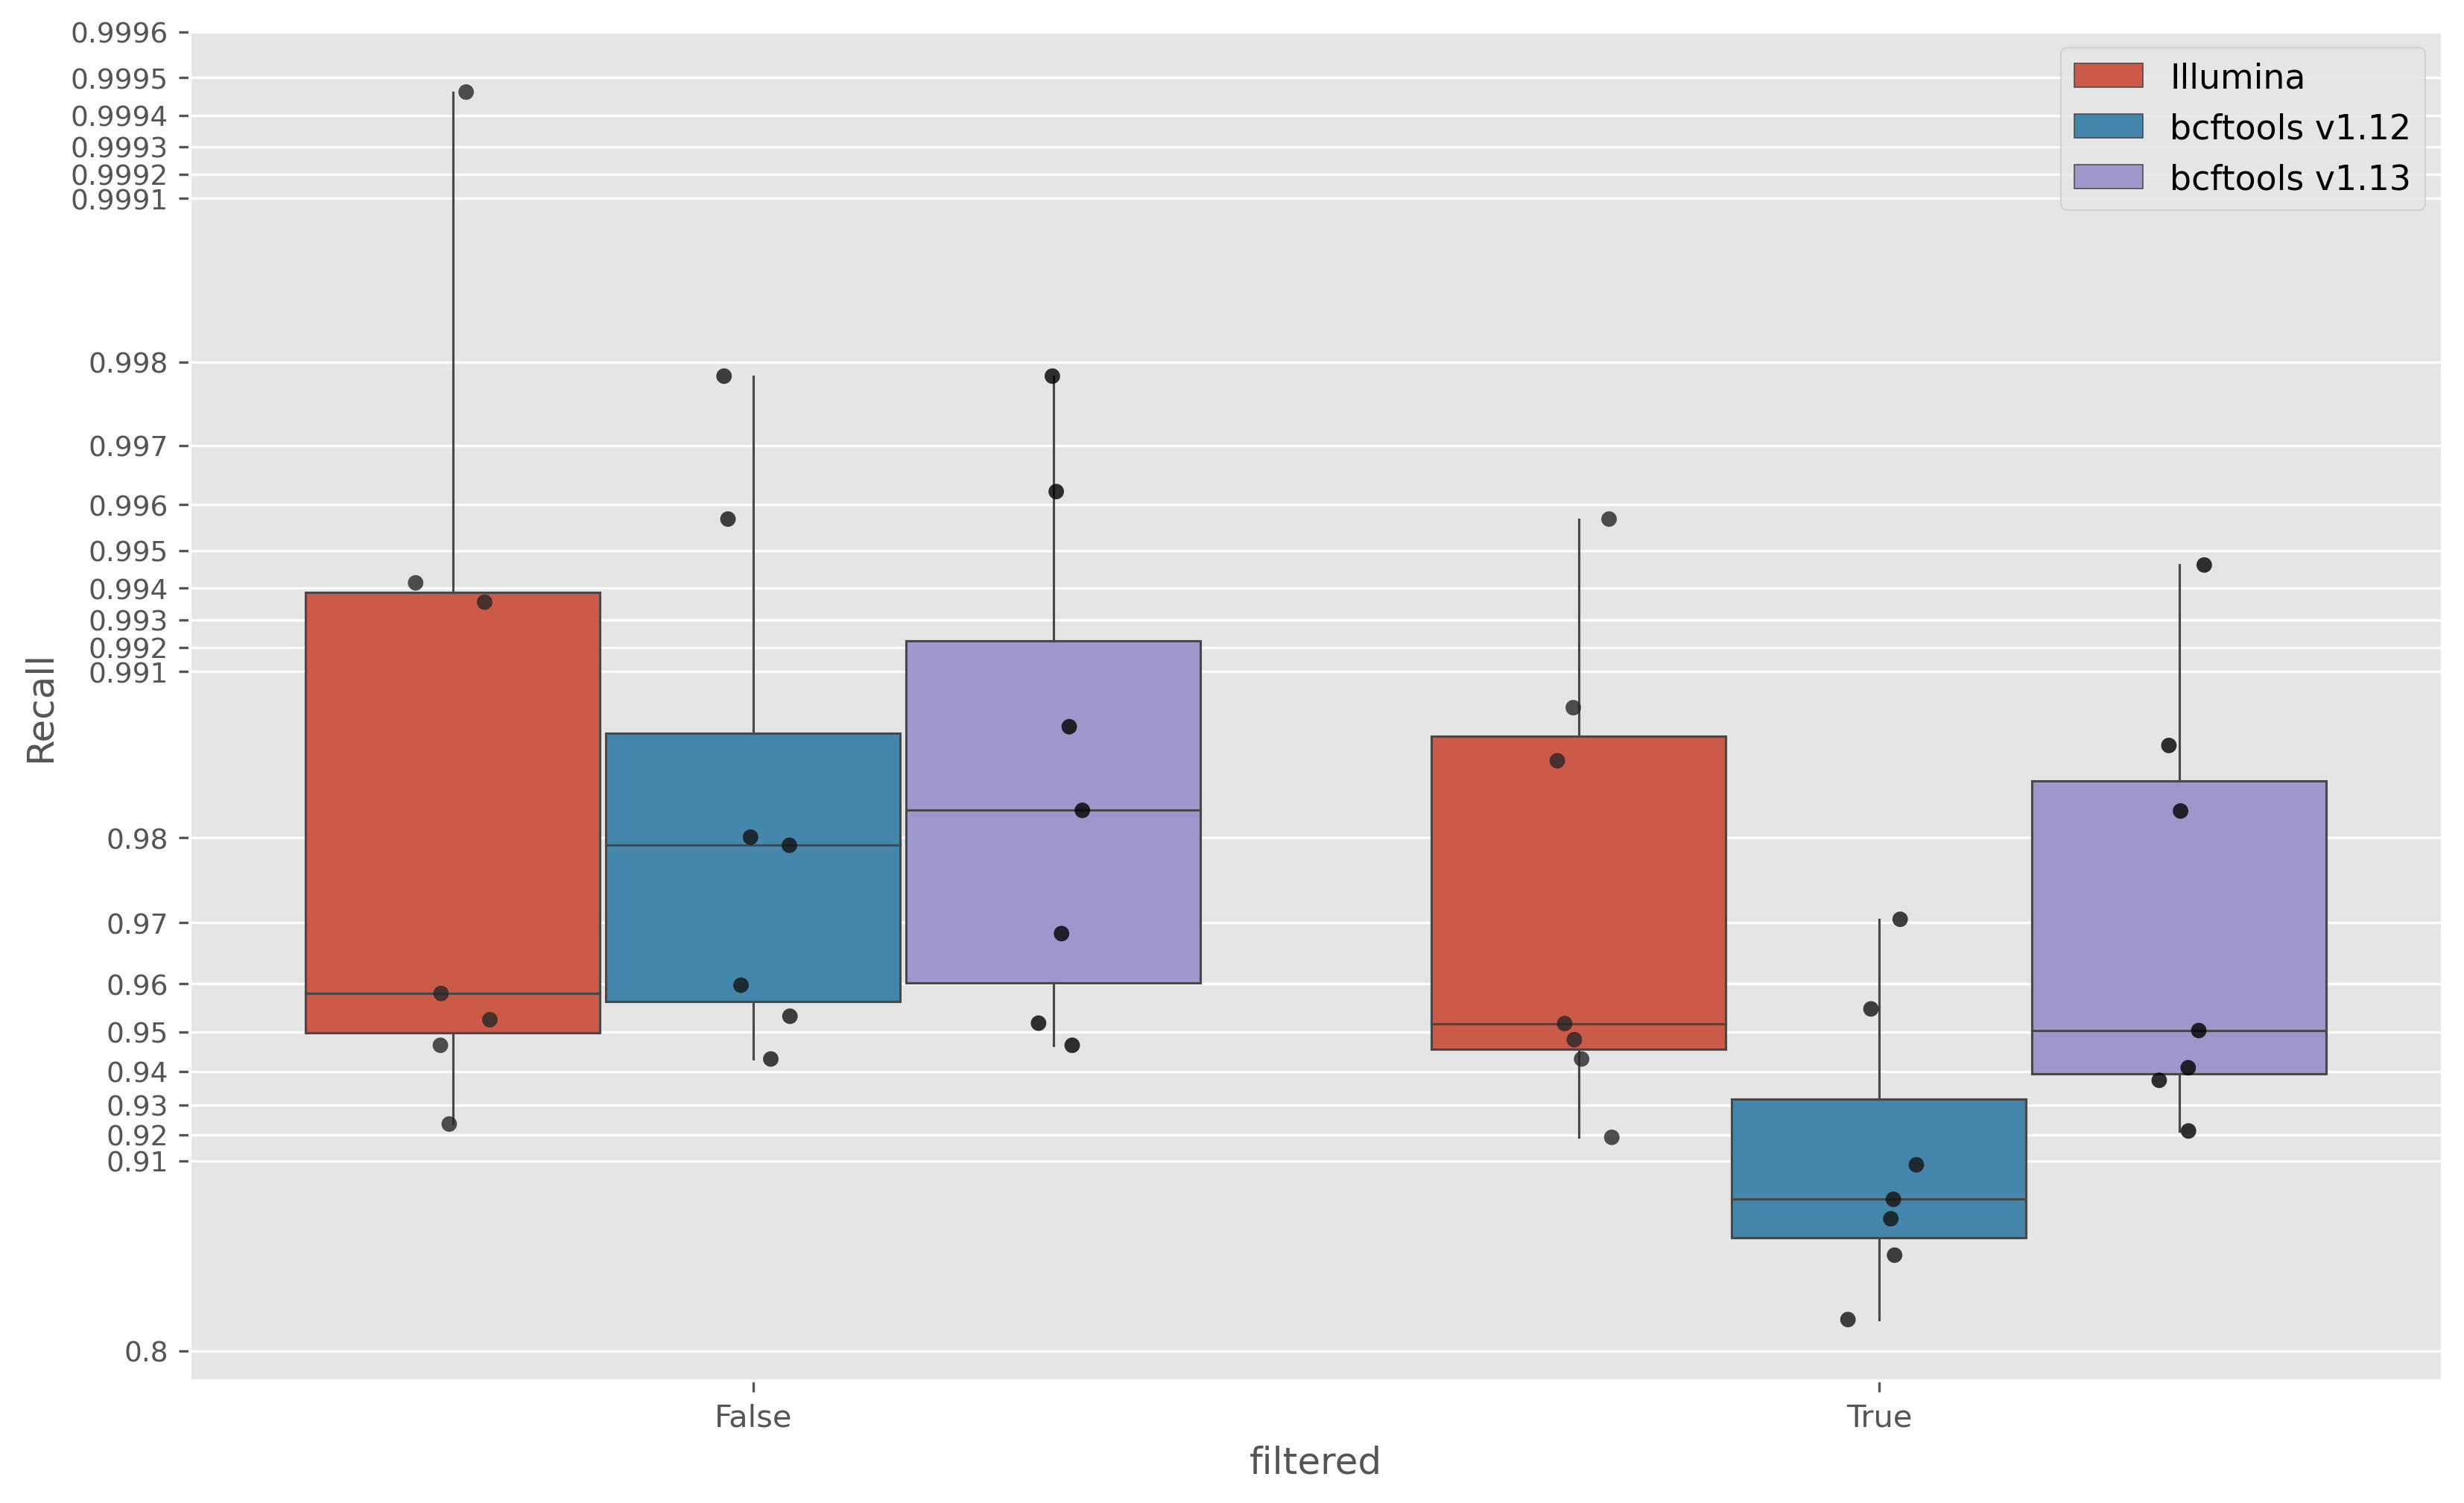

In [184]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)


In [115]:
help(plt.minorticks_on)

Help on function minorticks_on in module matplotlib.pyplot:

minorticks_on()
    Display minor ticks on the axes.
    
    Displaying minor ticks may reduce performance; you may turn them off
    using `minorticks_off()` if drawing speed is a problem.



In [126]:
ax.get_yticklabels()[0].get_text()


'0.5'

In [143]:
tlab.get_position()[-1]

0.9999

In [144]:
val

0

In [145]:
tlab

Text(0, 0.9999, '')

In [160]:
for tlab in ax.get_yticklabels():
    x, y = tlab.get_position()
    print(x, y, y in ylabels)

0 0.8 True
0 0.85 True
0 0.9 True
0 0.92 True
0 0.93 True
0 0.94 True
0 0.95 True
0 0.96 True
0 0.97 True
0 0.98 True
0 0.99 True
0 0.995 True
0 0.996 True
0 0.998 True
0 0.999 True
0 0.9995 True


In [153]:
x

0

In [154]:
y

0.9999

In [155]:
y in ylabels

False